In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import the libraries needed

In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 4.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.io
from collections import Counter
import pandas as pd
import json
import random
import matplotlib.pyplot as plt
from itertools import chain
from scipy.interpolate import make_interp_spline
from scipy.stats import norm
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from statsmodels.stats.multicomp import pairwise_gameshowell
# import pingouin as pg
from scipy.interpolate import make_interp_spline
from scipy import signal
import math
import matplotlib.font_manager as fm
from scipy.stats import sem
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# import emoji

In [ ]:
pip install mat73

#Functions

**Water Availability**:
Function to find the 1st correct trial with water

In [3]:
def water_availability(datas):
    new_list = np.array([[array.item() for array in inner_list] for inner_list in datas])
    first_occurrences = [
        (sub_list.tolist().index(1) if 1 in sub_list.tolist() else len(sub_list) - 1) if len(sub_list) > 0 else None
        for sub_list in new_list
    ]
    first_occurrences_ = np.array([[] if value is None else [value] for value in first_occurrences])
    return first_occurrences_[0][0]

**Memory Index**: Function to compute the net probability of an animal poking in a certain direction in a trial by trial basis.

In [4]:
def MemoryIndex(hist_seq, port_seq ):
  cosAng = np.cos([ np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])

  MIsess=[]
  for ss in range(len(hist_seq)):
    if port_seq[ss] > 0:
      if np.sum(hist_seq[ss])>0:
        Projected_hist_norm=(hist_seq[ss] / np.sum(hist_seq[ss]))
        Projected_hist=Projected_hist_norm*np.roll(cosAng, int(port_seq[ss]) - 2, axis=0)
        MIsess.append(np.sum(Projected_hist))
      else:
        MIsess.append(np.nan)

    else:
      Projected_hist= np.nan
      MIsess.append(Projected_hist)

  MIsess_arr=np.array(MIsess)
  return MIsess_arr

**Memory Index by Trial**:
Function to compute the net probability of an animal poking in a certain direction in a trial by trial basis.

In [5]:
def MemoryIndexbyTrl(hist_seq, port_seq):
    cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])

    MITrl = np.zeros(8)  # Initialize an array to store the result

    if port_seq > 0:
        Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)
        Projected_hist_seq = np.roll(cosAng, int(port_seq) - 2) *Projected_hist_seq_norm
        MITrl = np.sum(Projected_hist_seq)
    else:
      MITrl=np.nan

    return MITrl

**Sliding Window**


In [6]:
def sliding_window(sequence, window_size):
    return np.array([sequence[i:i+window_size] for i in range(len(sequence) - window_size + 1)])

Flattening nested structures from MATLAB

In [7]:
def flatten_item(item):
    if isinstance(item, (list, np.ndarray)):
        if len(item) == 1 and isinstance(item[0], (list, np.ndarray)):
            # If the item is a list containing a single element (another list), don't flatten it
            return flatten_item(item[0])
        else:
            result = np.empty(len(item), dtype=object)
            for i, subitem in enumerate(item):
                result[i] = flatten_item(subitem)
            return result
    else:
        return item if isinstance(item, np.ndarray) else item.tolist()

def flatten_structure(structure):
    flattened_list = flatten_item(structure)
    return np.concatenate(flattened_list)


**Circular Distance:** Computes the distance in Radians of the ports

In [8]:
def circular_distance(angle1, angle2):
  angle_difference = np.abs(angle2 - angle1)
  wrapped_angle_difference = np.minimum(angle_difference, 2 * np.pi - angle_difference)
  return wrapped_angle_difference

# distance=np.array(circular_distance(prts,prts2))*8/(2*np.pi)

**Surrogates**:
- Normal
- By distance
- Big Histogram

In [9]:
def surrogatesbytrl(hist_seq, port_seq):
  """Inputs: the matrix of the histograms,  the list of ports and the trl"""
  new_hist=np.array([[hist_seq[aa][ss] for ss in range(len(hist_seq[aa]))] for aa in range(len(hist_seq))])
  Hist_data = list(chain.from_iterable(new_hist))

  new_port_seq=list(chain.from_iterable(port_seq))
  random.shuffle(new_port_seq)

  MI_Surr=[MemoryIndexbyTrl(Hist_data[smpl], new_port_seq[smpl]) for smpl in range(len(new_port_seq))]

  return np.nanmean(MI_Surr)

In [10]:
def surrogatesbyday(hist_seq, port_seq):
  """Inputs: the matrix of the histograms,  the list of ports and the trl"""
  new_hist=np.array([[hist_seq[aa][ss] for ss in range(len(hist_seq[aa]))] for aa in range(len(hist_seq))])
  Hist_data = list(chain.from_iterable(new_hist))

  new_port_seq=list(chain.from_iterable(port_seq))
  random.shuffle(new_port_seq)

  MI_Surr=[MemoryIndexbyTrl(Hist_data[smpl], new_port_seq[smpl]) for smpl in range(len(new_port_seq))]

  return np.nanmean(MI_Surr)

In [11]:
def surrogastes_BigHist(hist_seq,port_seq ):

  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=np.array(list(chain.from_iterable(port_seq)))
  random.shuffle(new_port_seq)

  ## I am centering all the histograms to the 8th port and adding them in a big histogram
  big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)

  ## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
  MI_Surr=MemoryIndexbyTrl(big_hist, 4)
  return MI_Surr

In [12]:
def surrogatesbytrl(hist_seq, port_seq, NumTrials):
  """Inputs: the matrix of the histograms,  the list of ports and the trl"""

  # NON_0_port_seq=[port_seq[aa][port_seq[aa]!=0] for aa in range(len(port_seq))]
  # NON_0_hist_seq=[hist_seq[aa][port_seq[aa]!=0] for aa in range(len(port_seq))]
  NON_0_port_seq=port_seq
  NON_0_hist_seq=hist_seq

  Nanimasl=len(NON_0_port_seq)
  NSess=max([len(aa) for aa in NON_0_port_seq])

  MI_Surr=np.full((Nanimals, NSess, NumTrials), np.nan)

  for aa in range(len(NON_0_port_seq)):
    for ss in range(len(NON_0_port_seq[aa])):
      random.shuffle(NON_0_port_seq[aa])
      for trl in range(NumTrials):
        MI_Surr[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])


  MI_SurrMean=np.array([np.nanmean(MI_Surr[:,:,trl]) for trl in range(np.shape(MI_Surr)[2])])

  return  MI_SurrMean

# RECALL

In [35]:
def CleaningRawDataset_REC(DrugType='CONTROL', FlagforSessions='CONTROL'):
  pathData= '/content/gdrive/MyDrive/Data8port/'
  fileName1='Output_8PortMazeAnalAVerRecallAllAnimals8Batch.mat'
  fileName2='Output_8PortMazeAnalAVerRecallAllAnimals9Batch.mat'
  fileName3='Output_8PortMazeAnalAVerRecallAllAnimals11Batch.mat'
  fileName4='Output_8PortMazeAnalAVerRecallAllAnimals12Batch.mat'
  # Load data from files
  S = [scipy.io.loadmat(pathData + fileName) for fileName in [fileName1, fileName2, fileName3, fileName4]]
  # Parameters
  StaMin = 3
  StaMax = 3
  MinNumTrials = 1

  if DrugType=='CONTROL':
    DrugType=[0, 1, 3, 5, 8, 9, 7] ##CONTROL or non infused
  if DrugType=='NMDA':
    DrugType=[6, 10]  ## anti_NMDAR infused animals
  if DrugType=='LGI1':
    DrugType=[11]   ## anti_LGI1 infused animals


  X = []
  ALL_FirstTrlWWater_REC=[]
  ALL_FirstTrlWaterAvai_REC=[]
  ALL_portsPoked_REC = []
  ALL_OnlyCorrectPortsPoked_REC = []
  ALL_IntTrialportsPoked_REC = []
  ALL_PORTS_REC =[]
  WATER = []
  CP = []

  # Loop over batches
  for bb in range(len(S)):
      if bb == 0:
        if FlagforSessions=='CONTROL':
          YearStart, MonthStart, DayStart = 2019, 10, 21 # This is the real original start
          YearEnd, MonthEnd, DayEnd = 2020, 12, 31 # This is the real original end
          # ## HIGH PERFORMERS
        if FlagforSessions=='NMDA':
          YearStart, MonthStart, DayStart = 2020, 1, 11 #24 days before the NMDA infusion period
          YearEnd, MonthEnd, DayEnd =   2020, 3, 8 # Day of NMDA end
                  # ## HIGH PERFORMERS
        if FlagforSessions=='LGI1':
          YearStart, MonthStart, DayStart = 2020, 6, 12 #15 days before LGI1
          YearEnd, MonthEnd, DayEnd = 2020, 7, 17 #Day After LGI1

      elif bb == 1:
        if FlagforSessions=='CONTROL':
          YearStart, MonthStart, DayStart = 2021, 1, 1 # This is the real original start
          YearEnd, MonthEnd, DayEnd = 2021, 7, 12 # This is the real original end
          ## HIGH PERFORMERS
        if FlagforSessions=='NMDA':
          YearStart, MonthStart, DayStart = 2021, 3, 26# 2021, 4, 12
          YearEnd, MonthEnd, DayEnd = 2021, 5, 19 #2021, 6, 2

        if FlagforSessions=='LGI1':
          YearStart, MonthStart, DayStart = 2021, 5, 24
          YearEnd, MonthEnd, DayEnd = 2021, 6, 24


      elif bb == 2:
        if FlagforSessions=='CONTROL':
          YearStart, MonthStart, DayStart = 2022, 1, 13# This is the real original start
          YearEnd, MonthEnd, DayEnd = 2022, 12, 31 # This is the real original end
        # ## HIGH PERFORMERS
        if FlagforSessions=='NMDA':
          YearStart, MonthStart, DayStart = 2022, 4, 8
          YearEnd, MonthEnd, DayEnd = 2022, 5, 5

        if FlagforSessions=='LGI1':
          YearStart, MonthStart, DayStart = 2022, 4, 8
          YearEnd, MonthEnd, DayEnd = 2022, 4, 25

      elif bb == 3:
        if FlagforSessions=='CONTROL':
          YearStart, MonthStart, DayStart = 2023, 10, 18# This is the real original start
          YearEnd, MonthEnd, DayEnd = 2024, 3, 1 # This is the real original end
        # # ## HIGH PERFORMERS
        # if FlagforSessions=='NMDA':
        #   YearStart, MonthStart, DayStart = 2022, 4, 8
        #   YearEnd, MonthEnd, DayEnd = 2022, 5, 5

        # if FlagforSessions=='LGI1':
        #   YearStart, MonthStart, DayStart = 2022, 4, 8
        #   YearEnd, MonthEnd, DayEnd = 2022, 4, 25



      YearStart_str = str(YearStart)
      MonthStart_str = str(MonthStart).zfill(2)
      DayStart_str = str(DayStart).zfill(2)
      YearEnd_str = str(YearEnd)
      MonthEnd_str = str(MonthEnd).zfill(2)
      DayEnd_str = str(DayEnd).zfill(2)

      start_date = np.datetime64(f'{YearStart_str}-{MonthStart_str}-{DayStart_str}')
      end_date = np.datetime64(f'{YearEnd_str}-{MonthEnd_str}-{DayEnd_str}')

      Nanimals = S[bb]['CorrectPortPOSTG'].shape[0]
      Nsess = S[bb]['CorrectPortPOSTG'].shape[1]

      anim_portsPoked = np.full((Nanimals,157,56) ,np.nan, dtype=object)
      anim_FirstTrlWWater=np.full((Nanimals,157),np.nan, dtype=object)
      anim_FirstTrlWaterAvai=np.full((Nanimals, 157),np.nan, dtype=object)
      anim_OnlyCorrectPortsPoked = []
      anim_IntTrialportsPoked = []
      anim_PORTS =np.full((Nanimals,157), 0)
      anim_WATER = []

      for aa in range(Nanimals):
          sess_portsPoked = np.full((157,56) ,np.nan, dtype=object)

          sess_OnlyCorrectPortsPoked = []
          sess_IntTrialportsPoked = []
          sess_PORTS = np.full(157 ,0, dtype=object)
          sess_WATER = []
          FirstTrlWWater=np.full(157,np.nan, dtype=object)
          FirstTrlWaterAvai=np.full(157,np.nan, dtype=object)

          for sess in range(Nsess):
              # print('Sess: ', sess)
              # Initialize session containers
              waterAvail = []
              portsPoked = np.full(56, np.nan,dtype=object)
              OnlyCorrectPortsPoked = []
              IntTrialportsPoked = []
              k = 0

              if not np.shape(S[bb]['POSTWaterAvailabilityPerAnimalSess'][aa][sess]) == (1, 0):
                  vec_day = S[bb]['ExpDay'][aa, sess, :].squeeze()
                  VecDay = np.datetime64(f'{vec_day[0]:04d}-{vec_day[1]:02d}-{vec_day[2]:02d}', 'D')
                  IN = 0

              if start_date <= VecDay <= end_date:
                  IN = 1

              if S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess][0].all():
                  if not S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess][0].all():
                      IN = 0
                  if MinNumTrials <= S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess].shape[1] and \
                          S[bb]['ExpParams'][aa, sess] is not None:
                      if StaMin <= S[bb]['ExpParams'][aa, sess][0][0] <= StaMax and IN == 1 and \
                              any((S[bb]['ExpParams'][aa, sess][0][1] - DrugType) == 0):
                          sess_PORTS[sess]=np.array(S[bb]['CorrectPortPOSTG'][aa, sess])
                          nw = 1
                          for i in range(len(S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0])):
                              if S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][i][0].all():
                                  nw += 1
                          FirstTrlWWater[sess]=water_availability(S[bb]['POSTWaterAvailabilityPerAnimalSess'][aa, sess])
                          for t in range(water_availability(S[bb]['POSTWaterAvailabilityPerAnimalSess'][aa, sess])):

                              if not np.isnan(S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess][0][t]) and \
                                      np.size(S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][t]!=0):
                                  portsPoked[t]=np.concatenate([S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][t][0].astype(float), np.array([S[bb]['CorrectPortPOSTG'][aa, sess].astype(float)])])
                              else:
                                  if not np.isnan(S[bb]['AllAnimalsSessTrialsPOSTCorrectTrialRT'][aa, sess][0][t]):
                                      portsPoked[t]=np.array([S[bb]['CorrectPortPOSTG'][aa, sess]], dtype=float)
                                      OnlyCorrectPortsPoked.append(S[bb]['CorrectPortPOSTG'][aa, sess].astype(float))
                                  if np.size(S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][t]!=0):
                                      portsPoked[t]=np.array(S[bb]['AllAnimalsSessTrialsPOSTIncorrPortLicked'][aa, sess][0][t][0].astype(float))
                                  if S[bb]['AllAnimalsSessTrialsPOSTErrorLickPortInd'][aa, sess][0][t][0].all():
                                      IntTrialportsPoked.extend(
                                          S[bb]['AllAnimalsSessTrialsPOSTErrorLickPortInd'][aa, sess][0][t])

              # ANIMALS VARIABLES APPENDING
              sess_portsPoked[sess]=np.array(portsPoked)
              sess_OnlyCorrectPortsPoked.append(np.array(OnlyCorrectPortsPoked))
              sess_IntTrialportsPoked.append(IntTrialportsPoked)
              # sess_PORTS[sess]=np.array(S[bb]['CorrectPortPOSTG'][aa, sess])

          # Session VARIABLES APPENDING
          anim_portsPoked[aa]=np.array(sess_portsPoked)
          anim_FirstTrlWWater[aa]=np.array(FirstTrlWWater)
          anim_FirstTrlWaterAvai[aa]=np.array(FirstTrlWaterAvai)
          anim_OnlyCorrectPortsPoked.append(sess_OnlyCorrectPortsPoked)
          anim_IntTrialportsPoked.append(sess_IntTrialportsPoked)
          anim_PORTS[aa]=np.array(sess_PORTS)

      # ALL VARIABLES APPENDING

      ALL_portsPoked_REC.extend(anim_portsPoked)
      ALL_FirstTrlWaterAvai_REC.extend(np.array(anim_FirstTrlWaterAvai))
      ALL_FirstTrlWWater_REC.extend(np.array(anim_FirstTrlWWater))
      # ALL_OnlyCorrectPortsPoked_REC.append(np.array(anim_OnlyCorrectPortsPoked))
      # ALL_IntTrialportsPoked_REC.append(np.array(anim_IntTrialportsPoked))#np.array(anim_IntTrialportsPoked))
      ALL_PORTS_REC.extend(np.array(anim_PORTS))
  return ALL_portsPoked_REC, ALL_PORTS_REC, ALL_FirstTrlWWater_REC

In [36]:
ALL_portsPoked_REC=CleaningRawDataset_REC()[0] ##Poked Ports ##AllSessions
ALL_PORTS_REC=CleaningRawDataset_REC()[1] ##Ports Sequence ##AllSessions
ALL_Water_REC=CleaningRawDataset_REC()[2] ##Ports Sequence ##AllSessions

## Creating the HIST_ALL RECALL

In [37]:
def hist_all(port_seq, ports_poked,NumTrials):
  # ADJUSTING THE ARRAYS TO CREATE MATRIX
  AngRad_dict = {1: np.pi/4, 2: 0, 3: -np.pi/4, 4: -np.pi/2, 5: -3*np.pi/4, 6: np.pi, 7: 3*np.pi/4, 8: np.pi/2}
  cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])
  ALL_portsPoked_3D_arr_REC=np.array(ports_poked)
  max_length_nested_arrays=np.shape(ports_poked)[2]
  port_seq_REC=np.array(port_seq)
  # HIST SEQUENCE
  hist_all_REC=[]
  for aa in range(len(ALL_portsPoked_3D_arr_REC)):
    hist_anim_REC=[]
    for s, sess in enumerate(ALL_portsPoked_3D_arr_REC [aa]):
        hist_sess_REC=[]
        for trl in range(NumTrials):
          if np.shape(ALL_portsPoked_3D_arr_REC [aa,s,trl])==() or  np.shape(ALL_portsPoked_3D_arr_REC [aa,s,trl])==(0,):
            hist_sess_REC.append(np.array([0 for _ in range(8)]))
          else:
            filtered_pokes = np.array(np.hstack(ALL_portsPoked_3D_arr_REC [aa,s,trl]).tolist())
            port_counts = Counter(filtered_pokes)
            hist_sess_REC.append(np.array([port_counts[port] for port in AngRad_dict]))
        hist_anim_REC.append(hist_sess_REC)
    hist_all_REC.append(np.array(hist_anim_REC))

  hist_all_REC_arr=np.array(hist_all_REC)
  return hist_all_REC_arr

## Collapsed Datasets

In [17]:
AngRad_dict = {1: np.pi/4, 2: 0, 3: -np.pi/4, 4: -np.pi/2, 5: -3*np.pi/4, 6: np.pi, 7: 3*np.pi/4, 8: np.pi/2}
cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])
NumTrials=20
##CONTROL
hist_all_REC_arr=hist_all(ALL_PORTS_REC, ALL_portsPoked_REC, NumTrials)
port_seq_REC=ALL_PORTS_REC
port_seqRec=np.array([np.roll(port_seq_REC[i],-np.nonzero(port_seq_REC[i])[0][0] ) for i in range(len(port_seq_REC))]) #Choses the 1sst value non zero for all the animals (this is just to compute the MI daily having a 1st reference and collapsing all of them together)
hist_REC=np.nansum(hist_all_REC_arr, axis=2)
hist_roll=np.array([np.roll(hist_REC[i],-np.nonzero(port_seq_REC[i])[0][0] , axis=0) for i in range(len(port_seq_REC))])
New_port_seq_REC=[[port_seqRec[aa][ss] if not np.sum(hist_roll[aa][ss])==0 else 0 for ss in range(len(port_seqRec[aa])) ]for aa in range(len(port_seqRec))]
New_port_seq_REC_arr=np.array(New_port_seq_REC)

Yesterdays_port_seq_REC=np.roll(New_port_seq_REC_arr, -1)
Ports_Seq_Rad=np.array([np.array([AngRad_dict[port_seq_REC[aa][ss]]  if port_seq_REC[aa][ss]!=0 else 0 for ss in range(len(port_seq_REC[aa])) ])for aa in range(len(port_seq_REC))])


# Mean By TRIAL:  By trial dataset


In [38]:
AngRad_dict = {1: np.pi/4, 2: 0, 3: -np.pi/4, 4: -np.pi/2, 5: -3*np.pi/4, 6: np.pi, 7: 3*np.pi/4, 8: np.pi/2}
cosAng = np.cos([np.pi/4, 0, -np.pi/4, -np.pi/2, -3/4*np.pi, np.pi, 3/4*np.pi, np.pi/2])
NumTrials=22
##CONTROL
hist_all_REC_arr=hist_all(ALL_PORTS_REC, ALL_portsPoked_REC, NumTrials)
port_seq_REC=ALL_PORTS_REC
possible_ports=np.array([1,2,3,4,5,6,7,8])
## Adding zeros to those sessions where an animal didn't do anything (hist_all=0)
New_port_seq_REC_arr=np.array([[port_seq_REC[aa][ss] if not np.sum(hist_all_REC_arr[aa][ss])==0 else 0 for ss in range(len(port_seq_REC[aa])) ]for aa in range(len(port_seq_REC))])

# Ports_Seq_Rad=np.array([np.array([AngRad_dict[port_seq_REC[aa][ss]]  if port_seq_REC[aa][ss]!=0 else 0 for ss in range(len(port_seq_REC[aa])) ])for aa in range(len(port_seq_REC))])
NON_0_port_seq=[New_port_seq_REC_arr[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(New_port_seq_REC_arr))]
NON_0_hist_seq=[hist_all_REC_arr[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(New_port_seq_REC_arr))]
NON_0_water=[ALL_Water_REC[aa][New_port_seq_REC_arr[aa]!=0] for aa in range(len(New_port_seq_REC_arr))]

NON_0_yes_port_seq= [np.roll(seq, 1) for seq in NON_0_port_seq]

MIbyTrl=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrlLag=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrlOP=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
for aa in range(len(NON_0_hist_seq)):
  for ss in range(len(NON_0_hist_seq[aa])):
    OP_PortSeq=np.roll(possible_ports, 8-NON_0_port_seq[aa][ss])[3]
    for trl in range(NumTrials):
      MIbyTrl[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_port_seq[aa][ss])
      MIbyTrlOP[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], OP_PortSeq)
      MIbyTrlLag[aa, ss, trl]=MemoryIndexbyTrl(NON_0_hist_seq[aa][ss][trl], NON_0_yes_port_seq[aa][ss])

<ipython-input-5-0466680c5dc8>:7: RuntimeWarning: invalid value encountered in divide
  Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)


In [ ]:
# NumTrials=30
# Nshuffles=3000
# MISurrByTrl=np.full((Nshuffles, NumTrials), np.nan)
# for i in range(Nshuffles):
#   MISurrByTrl[i]=surrogatesbytrl(hist_all_REC_arr,New_port_seq_REC_arr, NumTrials)

# folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
# np.savetxt(folder +  "ShuffleRECMISurrByTrl3000.csv", MISurrByTrl, delimiter=",")

In [ ]:
MISurrByTrl = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/ShuffleRECMISurrByTrl3000.csv",  delimiter=",")

In [ ]:
MIMeanByTrl=[np.nanmean(MIbyTrl[:,:,trl]) for trl in range(np.shape(MIbyTrl)[2])]
MIbyTrl_SEM=np.array([np.nanstd(MIbyTrl[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrl[:,:,trl]))) for trl  in range(np.shape(MIbyTrl)[2])])
MIMeanByTrlLag=[np.nanmean(MIbyTrlLag[:,:,trl]) for trl in range(np.shape(MIbyTrlLag)[2])]
MIbyTrlLag_SEM=np.array([np.nanstd(MIbyTrlLag[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrlLag[:,:,trl]))) for trl  in range(np.shape(MIbyTrlLag)[2])])

MISurrByTrl_Mean=np.nanmean(MISurrByTrl, axis=0)
MISurrByTrl_CI=np.array([np.array(np.percentile(MISurrByTrl[:,i], [97.5, 2.5])) for i in range(len(MISurrByTrl_Mean))])

NSamples=[np.sum(~np.isnan(MIbyTrlLag[:,:,trl])) for trl  in range(np.shape(MIbyTrlLag)[2])]
MinNumSamp= np.array([i if n<40 else np.nan for i, n in enumerate(NSamples)])
x=np.arange(NumTrials)

fig,axs=plt.subplots(2,1,figsize=(5,5),  gridspec_kw={'height_ratios': [1, 2]})
axs[0].bar(x, NSamples, color='grey', alpha=0.4)
axs[0].axvline(MinNumSamp[~np.isnan(MinNumSamp)][0],color='red', alpha=0.4)
axs[0].spines[['top', 'right']].set_visible(False)
axs[0].tick_params(axis='both',labelsize=5)
axs[0].set_xlabel('Trial Number',  fontsize=7)
axs[0].set_ylabel('Count', fontsize=7)
axs[0].set_xticks(x,x.astype(int)+1 )

axs[1].errorbar(x, MIMeanByTrl, yerr=MIbyTrl_SEM, fmt='.-',color='tab:blue', alpha=0.4, label= 'Todays \nMemory Index')
axs[1].errorbar(x, MIMeanByTrlLag, yerr=MIbyTrlLag_SEM, fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
axs[1].plot(MISurrByTrl_Mean[:22], '--', color='grey', alpha=0.3)
axs[1].fill_between(x, MISurrByTrl_CI[:,0][:22], MISurrByTrl_CI[:,1][:22],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[1].axvline(MinNumSamp[~np.isnan(MinNumSamp)][0],color='red', alpha=0.4)
axs[1].axhline(y=0, color='grey', alpha=0.1)
axs[1].set_xticks(x,x.astype(int)+1 )
axs[1].tick_params(axis='both',labelsize=5)
axs[1].set_title(f'Mean Memory Index by Trial \nRECALL NTrials=22',  fontsize=8)
axs[1].spines[['top', 'right']].set_visible(False)
axs[1].set_xlabel('Trial Number',  fontsize=7)
axs[1].set_ylabel('Memory Index', fontsize=7)
axs[1].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
fig.tight_layout()


# Mean Distance by water Trial

In [41]:
Nanimals=np.shape(ALL_portsPoked_REC)[0]
Nsessions=np.shape(ALL_portsPoked_REC)[1]
NumTrials=22

Portseq5=[]
Histseq5=[]
Portseq10=[]
Histseq10=[]
Portseq15=[]
Histseq15=[]
Portseq20=[]
Histseq20=[]
for aa in range(len(NON_0_water)):
  mask = NON_0_water[aa] < 6
  Portseq5.append(NON_0_port_seq[aa][mask])
  Histseq5.append(NON_0_hist_seq[aa][mask])

  mask10 =(NON_0_water[aa]< 11) & (NON_0_water[aa]> 6)
  Portseq10.append(NON_0_port_seq[aa][mask10])
  Histseq10.append(NON_0_hist_seq[aa][mask10])

  mask15 =(NON_0_water[aa]< 16) & (NON_0_water[aa]> 11)
  Portseq15.append(NON_0_port_seq[aa][mask15])
  Histseq15.append(NON_0_hist_seq[aa][mask15])

  mask20 = NON_0_water[aa]<23
  Portseq20.append(NON_0_port_seq[aa][mask20])
  Histseq20.append(NON_0_hist_seq[aa][mask20])


MIbyTrl5=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrlLag5=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrl10=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrlLag10=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrl15=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrlLag15=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrl20=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
MIbyTrlLag20=np.full(np.shape(hist_all_REC_arr)[:3], np.nan)
for aa in range(len(Portseq5)):
  yesterday5=np.roll(Portseq5[aa], 1)
  for ss in range(len(Portseq5[aa])):
    for trl in range(NumTrials):
      MIbyTrl5[aa, ss, trl]=MemoryIndexbyTrl(Histseq5[aa][ss][trl], Portseq5[aa][ss])
      MIbyTrlLag5[aa, ss, trl]=MemoryIndexbyTrl(Histseq5[aa][ss][trl], yesterday5[ss])

for aa in range(len(Portseq10)):
  yesterday10=np.roll(Portseq10[aa], 1)
  for ss in range(len(Portseq10[aa])):
    for trl in range(NumTrials):
      MIbyTrl10[aa, ss, trl]=MemoryIndexbyTrl(Histseq10[aa][ss][trl], Portseq10[aa][ss])
      MIbyTrlLag10[aa, ss, trl]=MemoryIndexbyTrl(Histseq10[aa][ss][trl],  yesterday10[ss])

for aa in range(len(Portseq15)):
  yesterday15=np.roll(Portseq15[aa], 1)
  for ss in range(len(Portseq15[aa])):
    for trl in range(NumTrials):
      MIbyTrl15[aa, ss, trl]=MemoryIndexbyTrl(Histseq15[aa][ss][trl], Portseq15[aa][ss])
      MIbyTrlLag15[aa, ss, trl]=MemoryIndexbyTrl(Histseq15[aa][ss][trl], yesterday15[ss])

for aa in range(len(Portseq20)):
  yesterday20=np.roll(Portseq20[aa], 1)
  for ss in range(len(Portseq20[aa])):
    for trl in range(NumTrials):
      MIbyTrl20[aa, ss, trl]=MemoryIndexbyTrl(Histseq20[aa][ss][trl], Portseq20[aa][ss])
      MIbyTrlLag20[aa, ss, trl]=MemoryIndexbyTrl(Histseq20[aa][ss][trl], yesterday20[ss])


<ipython-input-5-0466680c5dc8>:7: RuntimeWarning: invalid value encountered in divide
  Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)


In [ ]:
NumTrials=5
Nshuffles=3000
MISurrByTrl=np.full((Nshuffles, NumTrials), np.nan)
for i in range(Nshuffles):
  MISurrByTrl[i]=surrogatesbytrl(Histseq5,Portseq5, NumTrials)

folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
np.savetxt(folder +  "ShuffleRECMISurrByTrlWATER5_3000.csv", MISurrByTrl, delimiter=",")

<ipython-input-5-775c3769da21>:7: RuntimeWarning: invalid value encountered in divide
  Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)


In [ ]:
NumTrials=5
Nshuffles=1000
MISurrByTrl5=np.full((Nshuffles, NumTrials), np.nan)
for i in range(Nshuffles):
  MISurrByTrl5[i]=surrogatesbytrl(Histseq5,Portseq5, NumTrials)

folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
np.savetxt(folder +  "ShuffleRECMISurrByTrlWATER5_cumulative_1000.csv", MISurrByTrl5, delimiter=",")

NumTrials=10
Nshuffles=1000
MISurrByTrl10=np.full((Nshuffles, NumTrials), np.nan)
for i in range(Nshuffles):
  MISurrByTrl10[i]=surrogatesbytrl(Histseq10,Portseq10, NumTrials)
folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
np.savetxt(folder +  "ShuffleRECMISurrByTrlWATER10_cumulative_1000.csv", MISurrByTrl10, delimiter=",")

NumTrials=15
MISurrByTrl15=np.full((Nshuffles, NumTrials), np.nan)
for i in range(Nshuffles):
  MISurrByTrl15[i]=surrogatesbytrl(Histseq15,Portseq15, NumTrials)
folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
np.savetxt(folder +  "ShuffleRECMISurrByTrlWATER15_cumulative_1000.csv", MISurrByTrl15, delimiter=",")

NumTrials=22
MISurrByTrl20=np.full((Nshuffles, NumTrials), np.nan)
for i in range(Nshuffles):
  MISurrByTrl20[i]=surrogatesbytrl(Histseq20, Portseq20, NumTrials)

folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
np.savetxt(folder +  "ShuffleRECMISurrByTrlWATER20_cumulative_1000.csv", MISurrByTrl20, delimiter=",")

<ipython-input-5-775c3769da21>:7: RuntimeWarning: invalid value encountered in divide
  Projected_hist_seq_norm = hist_seq / np.nansum(hist_seq)


In [20]:
MISurrByTrl5 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/ShuffleRECMISurrByTrlWATER5_cumulative_1000.csv",  delimiter=",")
MISurrByTrl10 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/ShuffleRECMISurrByTrlWATER10_cumulative_1000.csv",  delimiter=",")
MISurrByTrl15 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/ShuffleRECMISurrByTrlWATER15_cumulative_1000.csv",  delimiter=",")
MISurrByTrl20 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/ShuffleRECMISurrByTrlWATER20_cumulative_1000.csv",  delimiter=",")

<ipython-input-42-bc2622287b30>:1: RuntimeWarning: Mean of empty slice
  MIMeanByTrl5=[np.nanmean(MIbyTrl5[:,:,trl]) for trl in range(np.shape(MIbyTrl5)[2])]
<ipython-input-42-bc2622287b30>:3: RuntimeWarning: Mean of empty slice
  MIMeanByTrlLag5=[np.nanmean(MIbyTrlLag5[:,:,trl]) for trl in range(np.shape(MIbyTrlLag5)[2])]
<ipython-input-42-bc2622287b30>:6: RuntimeWarning: Mean of empty slice
  MIMeanByTrl10=[np.nanmean(MIbyTrl10[:,:,trl]) for trl in range(np.shape(MIbyTrl10)[2])]
<ipython-input-42-bc2622287b30>:8: RuntimeWarning: Mean of empty slice
  MIMeanByTrlLag10=[np.nanmean(MIbyTrlLag10[:,:,trl]) for trl in range(np.shape(MIbyTrlLag10)[2])]
<ipython-input-42-bc2622287b30>:11: RuntimeWarning: Mean of empty slice
  MIMeanByTrl15=[np.nanmean(MIbyTrl15[:,:,trl]) for trl in range(np.shape(MIbyTrl15)[2])]
<ipython-input-42-bc2622287b30>:13: RuntimeWarning: Mean of empty slice
  MIMeanByTrlLag15=[np.nanmean(MIbyTrlLag15[:,:,trl]) for trl in range(np.shape(MIbyTrlLag15)[2])]


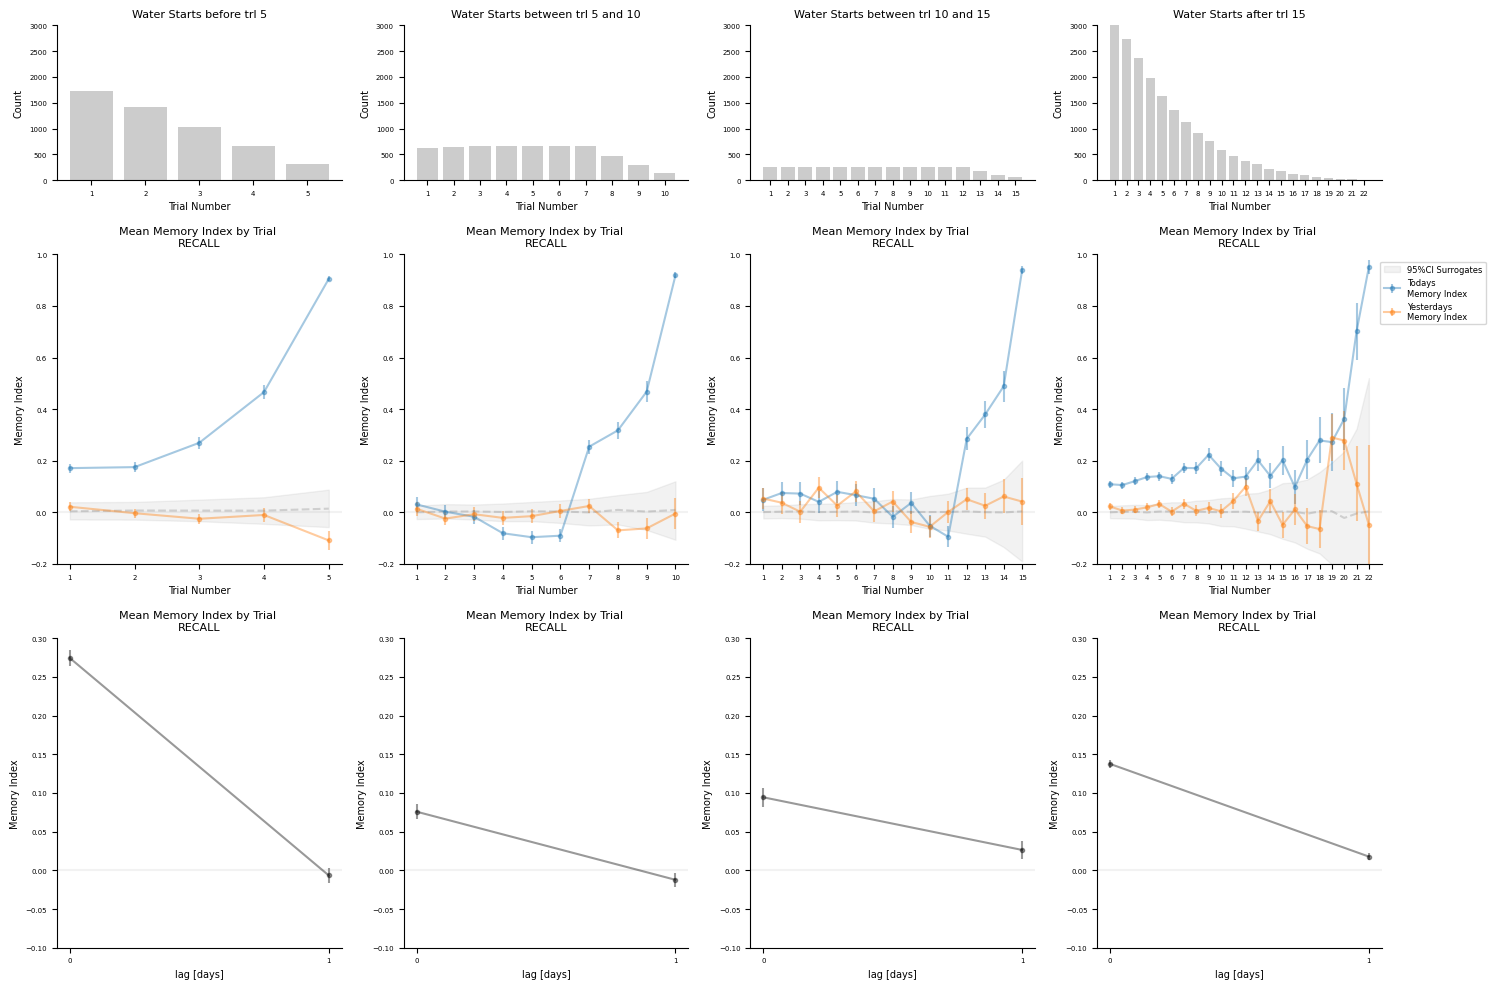

In [42]:
MIMeanByTrl5=[np.nanmean(MIbyTrl5[:,:,trl]) for trl in range(np.shape(MIbyTrl5)[2])]
MIbyTrl5_SEM=np.array([np.nanstd(MIbyTrl5[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrl5[:,:,trl]))) for trl  in range(np.shape(MIbyTrl5)[2])])
MIMeanByTrlLag5=[np.nanmean(MIbyTrlLag5[:,:,trl]) for trl in range(np.shape(MIbyTrlLag5)[2])]
MIbyTrlLag5_SEM=np.array([np.nanstd(MIbyTrlLag5[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrlLag5[:,:,trl]))) for trl  in range(np.shape(MIbyTrlLag5)[2])])

MIMeanByTrl10=[np.nanmean(MIbyTrl10[:,:,trl]) for trl in range(np.shape(MIbyTrl10)[2])]
MIbyTrl10_SEM=np.array([np.nanstd(MIbyTrl10[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrl10[:,:,trl]))) for trl  in range(np.shape(MIbyTrl10)[2])])
MIMeanByTrlLag10=[np.nanmean(MIbyTrlLag10[:,:,trl]) for trl in range(np.shape(MIbyTrlLag10)[2])]
MIbyTrlLag10_SEM=np.array([np.nanstd(MIbyTrlLag10[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrlLag10[:,:,trl]))) for trl  in range(np.shape(MIbyTrlLag10)[2])])

MIMeanByTrl15=[np.nanmean(MIbyTrl15[:,:,trl]) for trl in range(np.shape(MIbyTrl15)[2])]
MIbyTrl15_SEM=np.array([np.nanstd(MIbyTrl15[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrl15[:,:,trl]))) for trl  in range(np.shape(MIbyTrl15)[2])])
MIMeanByTrlLag15=[np.nanmean(MIbyTrlLag15[:,:,trl]) for trl in range(np.shape(MIbyTrlLag15)[2])]
MIbyTrlLag15_SEM=np.array([np.nanstd(MIbyTrlLag15[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrlLag15[:,:,trl]))) for trl  in range(np.shape(MIbyTrlLag15)[2])])

MIMeanByTrl20=[np.nanmean(MIbyTrl20[:,:,trl]) for trl in range(np.shape(MIbyTrl20)[2])]
MIbyTrl20_SEM=np.array([np.nanstd(MIbyTrl20[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrl20[:,:,trl]))) for trl  in range(np.shape(MIbyTrl20)[2])])
MIMeanByTrlLag20=[np.nanmean(MIbyTrlLag20[:,:,trl]) for trl in range(np.shape(MIbyTrlLag20)[2])]
MIbyTrlLag20_SEM=np.array([np.nanstd(MIbyTrlLag20[:,:,trl]) / np.sqrt(np.sum(~np.isnan(MIbyTrlLag20[:,:,trl]))) for trl  in range(np.shape(MIbyTrlLag20)[2])])

MISurrByTrl5_Mean=np.nanmean(MISurrByTrl5, axis=0)
MISurrByTrl5_CI=np.array([np.array(np.percentile(MISurrByTrl5[:,i], [97.5, 2.5])) for i in range(len(MISurrByTrl5_Mean))])

MISurrByTrl10_Mean=np.nanmean(MISurrByTrl10, axis=0)
MISurrByTrl10_CI=np.array([np.array(np.percentile(MISurrByTrl10[:,i], [97.5, 2.5])) for i in range(len(MISurrByTrl10_Mean))])

MISurrByTrl15_Mean=np.nanmean(MISurrByTrl15, axis=0)
MISurrByTrl15_CI=np.array([np.array(np.percentile(MISurrByTrl15[:,i], [97.5, 2.5])) for i in range(len(MISurrByTrl15_Mean))])

MISurrByTrl20_Mean=np.nanmean(MISurrByTrl20 , axis=0)
MISurrByTrl20_CI=np.array([np.array(np.percentile(MISurrByTrl20[:,i], [97.5, 2.5])) for i in range(len(MISurrByTrl20_Mean))])

Ntrials=5
NSamples=[np.sum(~np.isnan(MIbyTrlLag5[:,:,trl])) for trl  in range(np.shape(MIbyTrlLag5)[2])]
MinNumSamp= np.array([i if n<40 else np.nan for i, n in enumerate(NSamples)])
x=np.arange(Ntrials)

fig,axs=plt.subplots(3,4,figsize=(15,10),  gridspec_kw={'height_ratios': [1, 2,2]})
axs[0,0].bar(x, NSamples[:5], color='grey', alpha=0.4)
axs[0,0].spines[['top', 'right']].set_visible(False)
axs[0,0].tick_params(axis='both',labelsize=5)
axs[0,0].set_xlabel('Trial Number',  fontsize=7)
axs[0,0].set_ylabel('Count', fontsize=7)
axs[0,0].set_xticks(x,x.astype(int)+1 )
axs[0,0].set_title('Water Starts before trl 5', fontsize=8)
axs[0,0].set_ylim(0, 3000)

axs[1,0].errorbar(x[:Ntrials], MIMeanByTrl5[:Ntrials], yerr=MIbyTrl5_SEM[:Ntrials], fmt='.-',color='tab:blue', alpha=0.4, label= 'Todays \nMemory Index')
axs[1,0].errorbar(x[:Ntrials], MIMeanByTrlLag5[:Ntrials], yerr=MIbyTrlLag5_SEM[:Ntrials], fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
axs[1,0].plot(MISurrByTrl5_Mean[:22], '--', color='grey', alpha=0.3)
axs[1,0].fill_between(x, MISurrByTrl5_CI[:,0][:22], MISurrByTrl5_CI[:,1][:22],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[1,0].axhline(y=0, color='grey', alpha=0.1)
axs[1,0].set_xticks(x[:Ntrials],x[:Ntrials].astype(int)+1 )
axs[1,0].tick_params(axis='both',labelsize=5)
axs[1,0].set_title(f'Mean Memory Index by Trial \nRECALL',  fontsize=8)
axs[1,0].spines[['top', 'right']].set_visible(False)
axs[1,0].set_xlabel('Trial Number',  fontsize=7)
axs[1,0].set_ylabel('Memory Index', fontsize=7)
# axs[1,0].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
axs[1,0].set_ylim(-.2, 1)

x2=np.array([0,1])
axs[2,0].errorbar(x2, [np.nanmean(MIbyTrl5), np.nanmean(MIbyTrlLag5)], yerr=[np.nanstd(MIbyTrl5)/ np.sqrt(np.sum(~np.isnan(MIbyTrl5))),np.nanstd(MIbyTrlLag5)/ np.sqrt(np.sum(~np.isnan(MIbyTrlLag5))) ], fmt='.-',color='black', alpha=0.4, label= 'Todays \nMemory Index')
# axs[2,0].errorbar(x[:Ntrials], MIMeanByTrlLag5[:Ntrials], yerr=MIbyTrlLag5_SEM[:Ntrials], fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
# axs[2,0].plot(MISurrByTrl5_Mean[:22], '--', color='grey', alpha=0.3)
# axs[2,0].fill_between(x, MISurrByTrl5_CI[:,0][:22], MISurrByTrl5_CI[:,1][:22],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[2,0].axhline(y=0, color='grey', alpha=0.1)
axs[2,0].set_xticks(x2)
axs[2,0].tick_params(axis='both',labelsize=5)
axs[2,0].set_title(f'Mean Memory Index by Trial \nRECALL',  fontsize=8)
axs[2,0].spines[['top', 'right']].set_visible(False)
axs[2,0].set_xlabel('lag [days]',  fontsize=7)
axs[2,0].set_ylabel('Memory Index', fontsize=7)
# axs[1,0].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
axs[2,0].set_ylim(-.1, 0.3)


Ntrials1=10
NSamples=[np.sum(~np.isnan(MIbyTrlLag10[:,:,trl])) for trl  in range(np.shape(MIbyTrlLag10)[2])]
MinNumSamp= np.array([i if n<40 else np.nan for i, n in enumerate(NSamples)])
x=np.arange(Ntrials1)
axs[0,1].bar(x[:Ntrials1], NSamples[:Ntrials1], color='grey', alpha=0.4)
axs[0,1].spines[['top', 'right']].set_visible(False)
axs[0,1].tick_params(axis='both',labelsize=5)
axs[0,1].set_xlabel('Trial Number',  fontsize=7)
axs[0,1].set_ylabel('Count', fontsize=7)
axs[0,1].set_xticks(x[:Ntrials1],x[:Ntrials1].astype(int)+1 )
axs[0,1].set_title('Water Starts between trl 5 and 10', fontsize=8)
axs[0,1].set_ylim(0, 3000)

axs[1,1].errorbar(x[:Ntrials1], MIMeanByTrl10[:Ntrials1], yerr=MIbyTrl10_SEM[:Ntrials1], fmt='.-',color='tab:blue', alpha=0.4, label= 'Todays \nMemory Index')
axs[1,1].errorbar(x[:Ntrials1], MIMeanByTrlLag10[:Ntrials1], yerr=MIbyTrlLag10_SEM[:Ntrials1], fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
axs[1,1].plot(MISurrByTrl10_Mean[:Ntrials1], '--', color='grey', alpha=0.3)
axs[1,1].fill_between(x, MISurrByTrl10_CI[:,0][:Ntrials1], MISurrByTrl10_CI[:,1][:Ntrials1],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[1,1].axhline(y=0, color='grey', alpha=0.1)
axs[1,1].set_xticks(x[:Ntrials1],x[:Ntrials1].astype(int)+1 )
axs[1,1].tick_params(axis='both',labelsize=5)
axs[1,1].set_title(f'Mean Memory Index by Trial \nRECALL',  fontsize=8)
axs[1,1].spines[['top', 'right']].set_visible(False)
axs[1,1].set_xlabel('Trial Number',  fontsize=7)
axs[1,1].set_ylabel('Memory Index', fontsize=7)
# axs[1,0].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
axs[1,1].set_ylim(-.2, 1)

x2=np.array([0,1])
axs[2,1].errorbar(x2, [np.nanmean(MIbyTrl10), np.nanmean(MIbyTrlLag10)], yerr=[np.nanstd(MIbyTrl10)/ np.sqrt(np.sum(~np.isnan(MIbyTrl10))),np.nanstd(MIbyTrlLag10)/ np.sqrt(np.sum(~np.isnan(MIbyTrlLag10))) ],
                  fmt='.-',color='black', alpha=0.4, label= 'Todays \nMemory Index')
# axs[2,0].errorbar(x[:Ntrials], MIMeanByTrlLag5[:Ntrials], yerr=MIbyTrlLag5_SEM[:Ntrials], fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
# axs[2,0].plot(MISurrByTrl5_Mean[:22], '--', color='grey', alpha=0.3)
# axs[2,0].fill_between(x, MISurrByTrl5_CI[:,0][:22], MISurrByTrl5_CI[:,1][:22],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[2,1].axhline(y=0, color='grey', alpha=0.1)
axs[2,1].set_xticks(x2)
axs[2,1].tick_params(axis='both',labelsize=5)
axs[2,1].set_title(f'Mean Memory Index by Trial \nRECALL',  fontsize=8)
axs[2,1].spines[['top', 'right']].set_visible(False)
axs[2,1].set_xlabel('lag [days]',  fontsize=7)
axs[2,1].set_ylabel('Memory Index', fontsize=7)
# axs[1,0].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
axs[2,1].set_ylim(-.1, 0.3)

Ntrials1=15
NSamples=[np.sum(~np.isnan(MIbyTrlLag15[:,:,trl])) for trl  in range(np.shape(MIbyTrlLag15)[2])]
MinNumSamp= np.array([i if n<40 else np.nan for i, n in enumerate(NSamples)])
x=np.arange(Ntrials1)
axs[0,2].bar(x[:Ntrials1], NSamples[:Ntrials1], color='grey', alpha=0.4)
axs[0,2].spines[['top', 'right']].set_visible(False)
axs[0,2].tick_params(axis='both',labelsize=5)
axs[0,2].set_xlabel('Trial Number',  fontsize=7)
axs[0,2].set_ylabel('Count', fontsize=7)
axs[0,2].set_xticks(x[:Ntrials1],x[:Ntrials1].astype(int)+1 )
axs[0,2].set_title('Water Starts between trl 10 and 15', fontsize=8)
axs[0,2].set_ylim(0, 3000)

axs[1,2].errorbar(x[:Ntrials1], MIMeanByTrl15[:Ntrials1], yerr=MIbyTrl15_SEM[:Ntrials1], fmt='.-',color='tab:blue', alpha=0.4, label= 'Todays \nMemory Index')
axs[1,2].errorbar(x[:Ntrials1], MIMeanByTrlLag15[:Ntrials1], yerr=MIbyTrlLag15_SEM[:Ntrials1], fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
axs[1,2].plot(MISurrByTrl15_Mean[:Ntrials1], '--', color='grey', alpha=0.3)
axs[1,2].fill_between(x, MISurrByTrl15_CI[:,0][:Ntrials1], MISurrByTrl15_CI[:,1][:Ntrials1],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[1,2].axhline(y=0, color='grey', alpha=0.1)
axs[1,2].set_xticks(x[:Ntrials1],x[:Ntrials1].astype(int)+1 )
axs[1,2].tick_params(axis='both',labelsize=5)
axs[1,2].set_title(f'Mean Memory Index by Trial \nRECALL',  fontsize=8)
axs[1,2].spines[['top', 'right']].set_visible(False)
axs[1,2].set_xlabel('Trial Number',  fontsize=7)
axs[1,2].set_ylabel('Memory Index', fontsize=7)
# axs[1,0].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
axs[1,2].set_ylim(-.2, 1)

x2=np.array([0,1])
axs[2,2].errorbar(x2, [np.nanmean(MIbyTrl15), np.nanmean(MIbyTrlLag15)], yerr=[np.nanstd(MIbyTrl15)/ np.sqrt(np.sum(~np.isnan(MIbyTrl15))),np.nanstd(MIbyTrlLag15)/ np.sqrt(np.sum(~np.isnan(MIbyTrlLag15))) ],
                  fmt='.-',color='black', alpha=0.4, label= 'Todays \nMemory Index')
# axs[2,0].errorbar(x[:Ntrials], MIMeanByTrlLag5[:Ntrials], yerr=MIbyTrlLag5_SEM[:Ntrials], fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
# axs[2,0].plot(MISurrByTrl5_Mean[:22], '--', color='grey', alpha=0.3)
# axs[2,0].fill_between(x, MISurrByTrl5_CI[:,0][:22], MISurrByTrl5_CI[:,1][:22],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[2,2].axhline(y=0, color='grey', alpha=0.1)
axs[2,2].set_xticks(x2)
axs[2,2].tick_params(axis='both',labelsize=5)
axs[2,2].set_title(f'Mean Memory Index by Trial \nRECALL',  fontsize=8)
axs[2,2].spines[['top', 'right']].set_visible(False)
axs[2,2].set_xlabel('lag [days]',  fontsize=7)
axs[2,2].set_ylabel('Memory Index', fontsize=7)
# axs[1,0].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
axs[2,2].set_ylim(-.1, 0.3)

Ntrials1=22
NSamples=[np.sum(~np.isnan(MIbyTrlLag20[:,:,trl])) for trl  in range(np.shape(MIbyTrlLag15)[2])]
MinNumSamp= np.array([i if n<40 else np.nan for i, n in enumerate(NSamples)])
x=np.arange(Ntrials1)
axs[0,3].bar(x[:Ntrials1], NSamples[:Ntrials1], color='grey', alpha=0.4)
axs[0,3].spines[['top', 'right']].set_visible(False)
axs[0,3].tick_params(axis='both',labelsize=5)
axs[0,3].set_xlabel('Trial Number',  fontsize=7)
axs[0,3].set_ylabel('Count', fontsize=7)
axs[0,3].set_xticks(x,x.astype(int)+1 )
axs[0,3].set_title('Water Starts after trl 15', fontsize=8)
axs[0,3].set_ylim(0, 3000)

axs[1,3].errorbar(x, MIMeanByTrl20[:Ntrials1], yerr=MIbyTrl20_SEM[:Ntrials1], fmt='.-',color='tab:blue', alpha=0.4, label= 'Todays \nMemory Index')
axs[1,3].errorbar(x, MIMeanByTrlLag20[:Ntrials1], yerr=MIbyTrlLag20_SEM[:Ntrials1], fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
axs[1,3].plot(MISurrByTrl20_Mean[:Ntrials1], '--', color='grey', alpha=0.3)
axs[1,3].fill_between(x, MISurrByTrl20_CI[:,0][:Ntrials1], MISurrByTrl20_CI[:,1][:Ntrials1],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[1,3].axhline(y=0, color='grey', alpha=0.1)
axs[1,3].set_xticks(x[:Ntrials1],x[:Ntrials1].astype(int)+1 )
axs[1,3].tick_params(axis='both',labelsize=5)
axs[1,3].set_title(f'Mean Memory Index by Trial \nRECALL',  fontsize=8)
axs[1,3].spines[['top', 'right']].set_visible(False)
axs[1,3].set_xlabel('Trial Number',  fontsize=7)
axs[1,3].set_ylabel('Memory Index', fontsize=7)
axs[1,3].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
axs[1,3].set_ylim(-.2, 1)

x2=np.array([0,1])
axs[2,3].errorbar(x2, [np.nanmean(MIbyTrl20), np.nanmean(MIbyTrlLag20)], yerr=[np.nanstd(MIbyTrl20)/ np.sqrt(np.sum(~np.isnan(MIbyTrl20))),np.nanstd(MIbyTrlLag20)/ np.sqrt(np.sum(~np.isnan(MIbyTrlLag20))) ],
                  fmt='.-',color='black', alpha=0.4, label= 'Todays \nMemory Index')
# axs[2,0].errorbar(x[:Ntrials], MIMeanByTrlLag5[:Ntrials], yerr=MIbyTrlLag5_SEM[:Ntrials], fmt='.-',color='tab:orange', alpha=0.4, label= 'Yesterdays \nMemory Index')
# axs[2,0].plot(MISurrByTrl5_Mean[:22], '--', color='grey', alpha=0.3)
# axs[2,0].fill_between(x, MISurrByTrl5_CI[:,0][:22], MISurrByTrl5_CI[:,1][:22],color='grey', alpha=0.1, label='95%CI Surrogates')
axs[2,3].axhline(y=0, color='grey', alpha=0.1)
axs[2,3].set_xticks(x2)
axs[2,3].tick_params(axis='both',labelsize=5)
axs[2,3].set_title(f'Mean Memory Index by Trial \nRECALL',  fontsize=8)
axs[2,3].spines[['top', 'right']].set_visible(False)
axs[2,3].set_xlabel('lag [days]',  fontsize=7)
axs[2,3].set_ylabel('Memory Index', fontsize=7)
# axs[1,0].legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=6)
axs[2,3].set_ylim(-.1, 0.3)

fig.tight_layout()

#Mean MI by distance: REC

## Mean MI By distance

Computing the MI of today following exactly the same way as with the surrogate dataset

In [ ]:
## CONTROL
hist_seq=hist_roll
port_seq=New_port_seq_REC_arr
yes_seq=np.roll(New_port_seq_REC_arr,1)

MI=np.array([MemoryIndex(hist_seq[aa], port_seq[aa]) for aa in range(len(hist_seq))])

# Ploting

In [ ]:
dataset_sem=np.array([np.nanstd(MI[i]) / np.sqrt(np.sum(~np.isnan(Dataset[i]))) for i  in range(5)])

<ipython-input-133-e88115c3d073>:14: RuntimeWarning: Mean of empty slice
  axs[1].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)], color='tab:blue',  alpha=0.4)
<ipython-input-133-e88115c3d073>:25: RuntimeWarning: Mean of empty slice
  axs[2].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)], color='tab:blue',  alpha=0.4)
<ipython-input-133-e88115c3d073>:35: RuntimeWarning: Mean of empty slice
  axs[3].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)], color='tab:blue',  alpha=0.4)
<ipython-input-133-e88115c3d073>:45: RuntimeWarning: Mean of empty slice
  axs[4].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)],  color='tab:blue',  alpha=0.4)
<ipython-input-133-e88115c3d073>:55: RuntimeWarning: Mean of empty slice
  axs[5].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)],  color='tab:blue',  alpha=0.4)


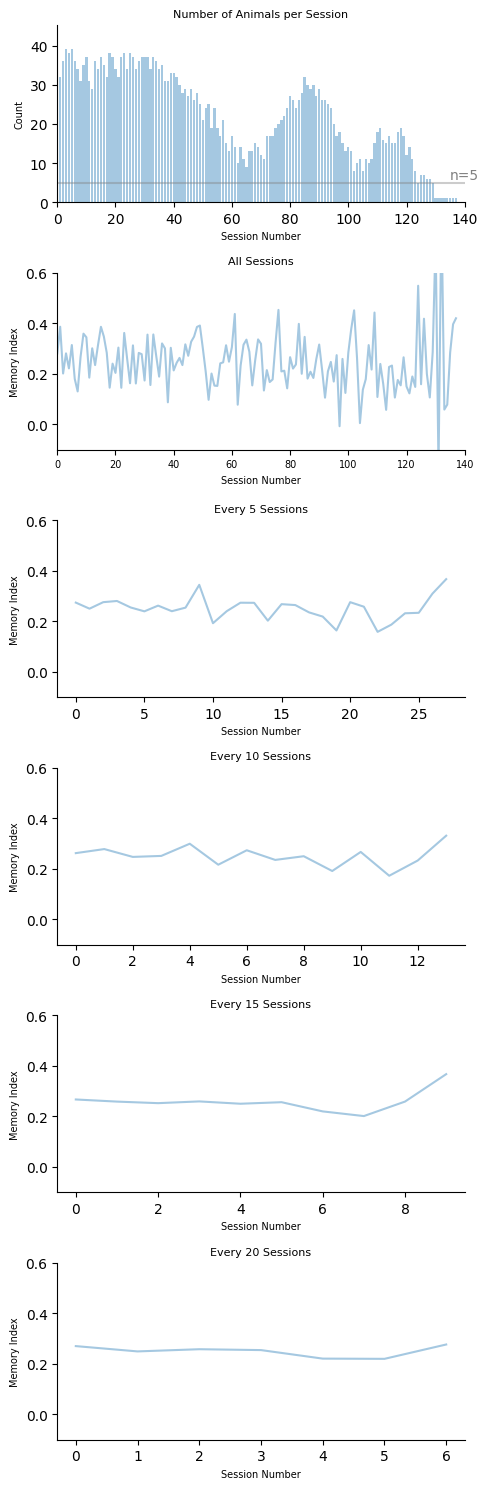

In [ ]:
fig,axs=plt.subplots(6,1,figsize=(5,15))
###CONTROL
Nanimals=np.array([len(MI.T[i][~np.isnan(MI.T[i])]) for i in range(len(MI.T))])
axs[0].bar(np.nonzero(Nanimals)[0], Nanimals[:np.nonzero(Nanimals)[0][-1]+1], color='tab:blue',  alpha=0.4)
axs[0].annotate('n=5', (135, 6), color='grey')
# axs[0].axhline(np.nanmean(np.nanmean(MI, axis=0)), color='tab:blue', alpha=0.6)
axs[0].set_xlim(0, 140)
axs[0].set_title('Number of Animals per Session', fontsize=8)
axs[0].spines[['top', 'right']].set_visible(False)
axs[0].axhline(y=5, color='grey', alpha=0.4)
axs[0].set_xlabel('Session Number', fontsize=7)
axs[0].set_ylabel('Count', fontsize=7)
n=1
axs[1].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)], color='tab:blue',  alpha=0.4)
axs[1].errorbar()
labels=axs[1].get_xticks()
new_labels=[i for i in range(0,len(MI.T), n*4)]
axs[1].set_xticks(labels, labels.astype(int),  fontsize=7)
axs[1].set_ylim(-0.1, 0.6)
axs[1].set_xlim(0, 140)
axs[1].set_title(f'All Sessions',  fontsize=8)
axs[1].spines[['top', 'right']].set_visible(False)
axs[1].set_xlabel('Session Number',  fontsize=7)
axs[1].set_ylabel('Memory Index', fontsize=7)
n=5
axs[2].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)], color='tab:blue',  alpha=0.4)
labels=axs[2].get_xticks()-1
new_labels=[i for i in range(0,len(MI.T), n*2)]
# axs[2].set_xticks(labels, new_labels)
axs[2].set_ylim(-0.1, 0.6)
axs[2].set_title(f'Every {n} Sessions', fontsize=8)
axs[2].spines[['top', 'right']].set_visible(False)
axs[2].set_xlabel('Session Number', fontsize=7)
axs[2].set_ylabel('Memory Index', fontsize=7)
n=10
axs[3].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)], color='tab:blue',  alpha=0.4)
labels=axs[3].get_xticks()-1
new_labels=[i for i in range(0,len(MI.T), n*2)]
# axs[2].set_xticks(labels, new_labels)
axs[3].set_ylim(-0.1, 0.6)
axs[3].set_title(f'Every {n} Sessions', fontsize=8)
axs[3].spines[['top', 'right']].set_visible(False)
axs[3].set_xlabel('Session Number', fontsize=7)
axs[3].set_ylabel('Memory Index', fontsize=7)
n=15
axs[4].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)],  color='tab:blue',  alpha=0.4)
labels=axs[2].get_xticks()-1
new_labels=[i for i in range(0,len(MI.T), n*2)]
# axs[2].set_xticks(labels, new_labels)
axs[4].set_ylim(-0.1, 0.6)
axs[4].set_title(f'Every {n} Sessions', fontsize=8)
axs[4].spines[['top', 'right']].set_visible(False)
axs[4].set_xlabel('Session Number', fontsize=7)
axs[4].set_ylabel('Memory Index', fontsize=7)
n=20
axs[5].plot([np.nanmean(np.nanmean(MI, axis=0)[i:i+n]) for i in range(0, len(MI.T), n)],  color='tab:blue',  alpha=0.4)
labels=axs[2].get_xticks()-1
new_labels=[i for i in range(0,len(MI.T), n*2)]
# axs[2].set_xticks(labels, new_labels)
axs[5].set_ylim(-0.1, 0.6)
axs[5].set_title(f'Every {n} Sessions', fontsize=8)
axs[5].spines[['top', 'right']].set_visible(False)
axs[5].set_xlabel('Session Number', fontsize=7)
axs[5].set_ylabel('Memory Index', fontsize=7)

fig.tight_layout()

In [ ]:
group1=All_MItrl_REC[0]
group2=All_MItrl_REC[4]
t_statistic, p_valor = stats.ttest_ind(group1, group2)

# Imprimir los resultados
print('T-Test: Distance1 vs Distance4')
print("Statistics t:", t_statistic)
print("p val:", p_valor)

from scipy import stats
group0=All_MItrl_REC[0]
group1=All_MItrl_REC[1]
group2=All_MItrl_REC[2]
group3=All_MItrl_REC[3]
group4=All_MItrl_REC[4]
# Compute ANOVA
f_statistic, p_valor = stats.f_oneway(group0, group1, group2 ,group3, group4)

# Imprimir los resultados
print('ANOVA')
print("Statistics F:", f_statistic)
print("pVal:", p_valor)

T-Test: Distance1 vs Distance4
Statistics t: 0.7507699061173164
p val: 0.45510943058020814
ANOVA
Statistics F: 0.2549546456931464
pVal: 0.906621630878005


In [ ]:
folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
Nshuffles=5000
MI_shuf_REC=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuf_REC[n]=((surrogatesbydistance(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC, 0)))
file_name = "Shuffle_rec_HighPerf(forLGI1)_15Trls.csv"
np.savetxt(folder + file_name, MI_shuf_REC, delimiter=",")

Nshuffles=5000
MI_shuf_REC24=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuf_REC24[n]=((surrogatesbydistance(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC, 1)))
file_name = "Shuffle_rec24_HighPerf(forLGI1)_15Trls.csv"
np.savetxt(folder + file_name, MI_shuf_REC24, delimiter=",")

# Nshuffles=5000
# MI_shuf_REC_NMDA=np.full((Nshuffles, 5), np.nan)
# for n in range(Nshuffles):
#   MI_shuf_REC_NMDA[n]=((surrogatesbydistance(distance_seq_REC_NMDA,NON_0_hist_seq_REC_NMDA, NON_0_port_seq_REC_NMDA, 0)))
# file_name = "Shuffle_rec_HighPerf_15Trls_NMDA.csv"
# np.savetxt(folder + file_name, MI_shuf_REC_NMDA, delimiter=",")

# Nshuffles=5000
# MI_shuf_REC24_NMDA=np.full((Nshuffles, 5), np.nan)
# for n in range(Nshuffles):
#   MI_shuf_REC24_NMDA[n]=((surrogatesbydistance(distance_seq_REC_NMDA,NON_0_hist_seq_REC_NMDA, NON_0_port_seq_REC_NMDA, 1)))
# file_name = "Shuffle_rec24_HighPerf_15Trls_NMDA.csv"
# np.savetxt(folder + file_name, MI_shuf_REC24_NMDA, delimiter=",")

# Nshuffles=5000
# MI_shuf_REC_LGI1=np.full((Nshuffles, 5), np.nan)
# for n in range(Nshuffles):
#   MI_shuf_REC_LGI1[n]=((surrogatesbydistance(distance_seq_REC_LGI1,NON_0_hist_seq_REC_LGI1, NON_0_port_seq_REC_LGI1, 0)))
# file_name = "Shuffle_rec_HighPerf_10Trls_LGI1.csv"
# np.savetxt(folder + file_name, MI_shuf_REC_LGI1, delimiter=",")

# Nshuffles=5000
# MI_shuf_REC24_LGI1=np.full((Nshuffles, 5), np.nan)
# for n in range(Nshuffles):
#   MI_shuf_REC24_LGI1[n]=((surrogatesbydistance(distance_seq_REC_LGI1,NON_0_hist_seq_REC_LGI1, NON_0_port_seq_REC_LGI1, 1)))
# file_name = "Shuffle_rec24_HighPerf_10Trls_LGI1.csv"
# np.savetxt(folder + file_name, MI_shuf_REC24_LGI1, delimiter=",")

In [ ]:
def calculate_metrix(Dataset, Surrogate=False):
  if Surrogate==False:
    dataset_mean=np.array([np.nanmean(Dataset[i]) for i in range(5)])
    dataset_non_nan=[Dataset[i][~np.isnan(Dataset[i])] for i in range(5)]
    dataset_percentile=np.array([np.array(np.percentile(dataset_non_nan[i], [99.5, .5])) for i  in range(5)])
    dataset_sem=np.array([np.nanstd(Dataset[i]) / np.sqrt(np.sum(~np.isnan(Dataset[i]))) for i  in range(5)])
  if Surrogate==True:
    dataset_mean=np.array([np.nanmean(Dataset[:,i]) for i in range(5)])
    dataset_percentile=np.array([np.array(np.percentile(Dataset[:,i], [99.5, .5])) for i  in range(5)])
    dataset_sem=np.array([np.nanstd(Dataset[i]) / np.sqrt(np.sum(~np.isnan(Dataset[i]))) for i  in range(5)])

  return dataset_mean, dataset_percentile, dataset_sem


In [ ]:
## Importing Surrogates:
MI_shuf_REC = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_HighPerf(forLGI1)_5Trls.csv",  delimiter=",")
MI_shuf_REC24= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec24_HighPerf(forLGI1)_5Trls.csv",  delimiter=",")
# MI_shuf_REC_NMDA = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_HighPerf_5Trls_NMDA.csv",  delimiter=",")
# MI_shuf_REC24_NMDA= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec24_HighPerf_5Trls_NMDA.csv",  delimiter=",")
# MI_shuf_REC_LGI1= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_HighPerf_10Trls_LGI1.csv",  delimiter=",")
# MI_shuf_REC24_LGI1= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec24_HighPerf_10Trls_LGI1.csv",  delimiter=",")

### Plotting

Text(0.5, 1.0, 'Memory Index by Distance to previous rewarded port \n REC [Control for LGI1 15 trials]')

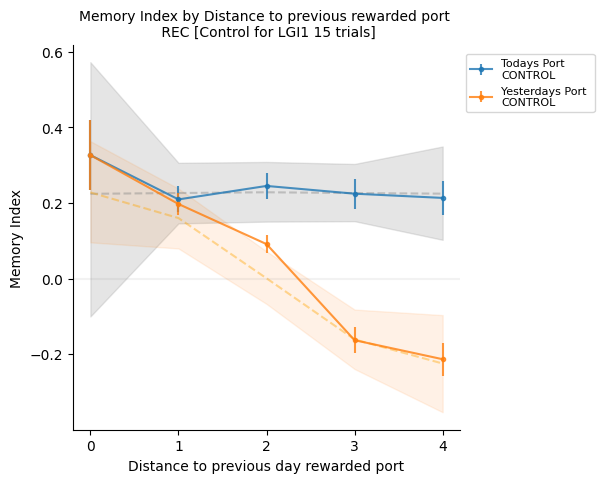

In [ ]:
x=np.arange(0, len(calculate_metrix(All_MItrl_REC)[0]), 1)
fig,axs=plt.subplots(figsize=(5,5))
###CONTROL
axs.plot(calculate_metrix(MI_shuf_REC, True)[0],'--' ,color='grey', alpha=0.4)
axs.fill_between(x,calculate_metrix(MI_shuf_REC, True)[1][:,0],calculate_metrix(MI_shuf_REC, True)[1][:,1], color='grey', alpha=0.2)
axs.plot(calculate_metrix(MI_shuf_REC24, True)[0], '--', color='orange', alpha=0.4)
axs.fill_between(x, calculate_metrix(MI_shuf_REC24, True)[1][:,0],calculate_metrix(MI_shuf_REC24, True)[1][:,1], color='tab:orange', alpha=0.1)

axs.errorbar(x,calculate_metrix(All_MItrl_REC)[0],  yerr=calculate_metrix(All_MItrl_REC)[2], fmt='.-', alpha=0.8 ,label='Todays Port \nCONTROL')
axs.errorbar(x,calculate_metrix(All_MItrlLags_REC)[0],  yerr=calculate_metrix(All_MItrlLags_REC)[2], fmt='.-', alpha=0.8 ,label='Yesterdays Port \nCONTROL')
axs.axhline(y=0,  linestyle='-', color='grey', alpha=0.1)

# ###NMDA
# axs.plot(calculate_metrix(MI_shuf_REC_NMDA, True)[0],'--' ,color='grey', alpha=0.4)
# axs.fill_between(x, calculate_metrix(MI_shuf_REC_NMDA, True)[1][:,0],calculate_metrix(MI_shuf_REC_NMDA,True)[1][:,1], color='grey', alpha=0.1)
# axs.plot(calculate_metrix(MI_shuf_REC24_NMDA,True)[0], '--', color='orange', alpha=0.4)
# axs.fill_between(x, calculate_metrix(MI_shuf_REC24_NMDA, True)[1][:,0],calculate_metrix(MI_shuf_REC24_NMDA,True)[1][:,1], color='tab:orange', alpha=0.1)

# axs.errorbar(x,calculate_metrix(All_MItrl_REC_NMDA)[0],  yerr=calculate_metrix(All_MItrl_REC_NMDA)[2], fmt='.-',color='tab:blue', alpha=0.4 ,label='Todays Port \nNMDA')
# axs.errorbar(x,calculate_metrix(All_MItrlLags_REC_NMDA)[0],  yerr=calculate_metrix(All_MItrlLags_REC_NMDA)[2], fmt='.-',color='tab:orange',alpha=0.4 ,label='Yesterdays Port \nNMDA')

# ###LGI1
# axs.plot(calculate_metrix(MI_shuf_REC_LGI1, True)[0],'--' ,color='grey', alpha=0.4)
# axs.fill_between(x, calculate_metrix(MI_shuf_REC_LGI1, True)[1][:,0],calculate_metrix(MI_shuf_REC_LGI1, True)[1][:,1], color='grey', alpha=0.2)
# axs.plot(calculate_metrix(MI_shuf_REC24_LGI1, True)[0], '--', color='orange', alpha=0.4)
# axs.fill_between(x, calculate_metrix(MI_shuf_REC24_LGI1, True)[1][:,0],calculate_metrix(MI_shuf_REC24_LGI1, True)[1][:,1], color='tab:orange', alpha=0.1)

# axs.errorbar(x,calculate_metrix(All_MItrl_REC_LGI1)[0],  yerr=calculate_metrix(All_MItrl_REC_LGI1)[2], fmt='.-',color='tab:blue', alpha=0.2 ,label='Todays Port \nLGI1')
# axs.errorbar(x,calculate_metrix(All_MItrlLags_REC_LGI1)[0],  yerr=calculate_metrix(All_MItrlLags_REC_LGI1)[2], fmt='.-',color='tab:orange',alpha=0.2,label='Yesterdays Port \nLGI1')


axs.set_ylabel('Memory Index')
axs.set_xlabel('Distance to previous day rewarded port')
axs.spines[['top', 'right']].set_visible(False)
axs.set_xticks(x)
axs.legend(loc='upper center', bbox_to_anchor=(1.18, .99), fancybox=True, fontsize=8)
axs.set_title('Memory Index by Distance to previous rewarded port \n REC [Control for LGI1 15 trials]', fontsize=10)

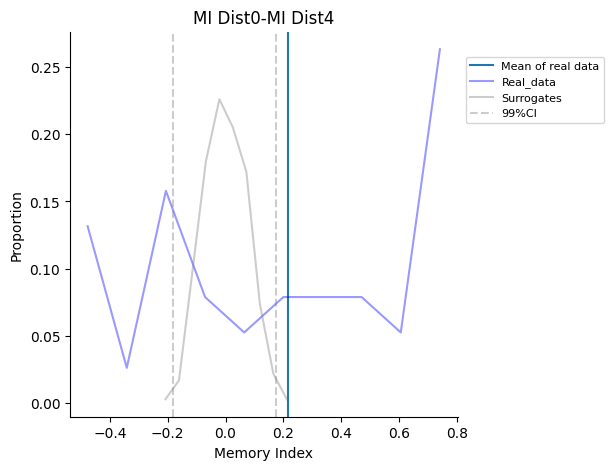

In [ ]:
X_distribution=All_MItrl_REC[0]-np.nanmean(All_MItrl_REC[4])
hist0=np.histogram(np.nanmean(MI_shuff_Surr_MI0MI4, axis=1))
hist1=np.histogram(X_distribution)
fig,axs=plt.subplots(figsize=(5,5))
axs.axvline(np.mean(X_distribution), label='Mean of real data')
axs.plot(hist1[1][:-1]+(hist1[1][:-1][1]- hist1[1][:-1][0])/2,hist1[0]/np.sum(hist1[0]), label="Real_data", color='blue', alpha=0.4)
axs.plot(hist0[1][:-1]+(hist0[1][:-1][1]- hist0[1][:-1][0])/2,hist0[0]/np.sum(hist0[0]), label="Surrogates", color='grey', alpha=0.4)
axs.axvline(np.percentile(np.nanmean(MI_shuff_Surr_MI0MI4, axis=1),[99.5, .5])[0], linestyle='--', color='grey', alpha=0.4, label='99%CI')
axs.axvline(np.percentile(np.nanmean(MI_shuff_Surr_MI0MI4, axis=1),[99.5, .5])[1], linestyle='--', color='grey', alpha=0.4)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Proportion')
axs.set_xlabel('Memory Index')
axs.set_title('MI Dist0-MI Dist4')
axs.legend(loc='upper center', bbox_to_anchor=(1.20, .95), fancybox=True, fontsize=8)
# axs.set_aspect('equal', adjustable='box')
# fig.tight_layout()

## BIG HIST

In [ ]:
folder = "/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/"
Nshuffles=5000
MI_shuf_REC=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuf_REC[n]=((surrogastesbydistance_BigHist(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC, 0)))
file_name = "Shuffle_rec_highPerf(forNMDA)_BIGHIST_10Trls.csv"
np.savetxt(folder + file_name, MI_shuf_REC, delimiter=",")

Nshuffles=5000
MI_shuf_REC24=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuf_REC24[n]=((surrogastesbydistance_BigHist(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC, 1)))
file_name = "Shuffle_rec24_highPerf(forNMDA)_BIGHIST_10Trls.csv"
np.savetxt(folder + file_name, MI_shuf_REC24, delimiter=",")

# Nshuffles=5000
# MI_shuf_REC_NMDA=np.full((Nshuffles, 5), np.nan)
# for n in range(Nshuffles):
#   MI_shuf_REC_NMDA[n]=((surrogastesbydistance_BigHist(distance_seq_REC_NMDA,NON_0_hist_seq_REC_NMDA, NON_0_port_seq_REC_NMDA, 0)))
# file_name = "Shuffle_rec_HighPerf_allSessions_5Trls_NMDA.csv"
# np.savetxt(folder + file_name, MI_shuf_REC_NMDA, delimiter=",")

# Nshuffles=5000
# MI_shuf_REC24_NMDA=np.full((Nshuffles, 5), np.nan)
# for n in range(Nshuffles):
#   MI_shuf_REC24_NMDA[n]=((surrogastesbydistance_BigHist(distance_seq_REC_NMDA,NON_0_hist_seq_REC_NMDA, NON_0_port_seq_REC_NMDA, 1)))
# file_name = "Shuffle_rec24_HighPerf_allSessions_5Trls_NMDA.csv"
# np.savetxt(folder + file_name, MI_shuf_REC24_NMDA, delimiter=",")

# Nshuffles=5000
# MI_shuf_REC_LGI1=np.full((Nshuffles, 5), np.nan)
# for n in range(Nshuffles):
#   MI_shuf_REC_LGI1[n]=((surrogastesbydistance_BigHist(distance_seq_REC_LGI1,NON_0_hist_seq_REC_LGI1, NON_0_port_seq_REC_LGI1, 0)))
# file_name = "Shuffle_rec_HighPerf_BIGHIST_15Trls_LGI1.csv"
# np.savetxt(folder + file_name, MI_shuf_REC_LGI1, delimiter=",")

# Nshuffles=5000
# MI_shuf_REC24_LGI1=np.full((Nshuffles, 5), np.nan)
# for n in range(Nshuffles):
#   MI_shuf_REC24_LGI1[n]=((surrogastesbydistance_BigHist(distance_seq_REC_LGI1,NON_0_hist_seq_REC_LGI1, NON_0_port_seq_REC_LGI1, 1)))
# file_name = "Shuffle_rec24_HighPerf_BIGHIST_15Trls_LGI1.csv"
# np.savetxt(folder + file_name, MI_shuf_REC24_LGI1, delimiter=",")

In [ ]:
##CONTROL
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC
yes_seq=[np.roll(seq,1) for seq in NON_0_port_seq_REC]
distance_seq=distance_seq_REC


Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

distance_seq=list(chain.from_iterable(distance_seq))

sess0=np.array(distance_seq)==0.0
sess1=np.array(distance_seq)==1.0
sess2=np.array(distance_seq)==2.0
sess3=np.array(distance_seq)==3.0
sess4=np.array(distance_seq)==4.0

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist0=np.sum([np.roll(Hist_data[sess0][ss],8-int(new_port_seq[sess0][ss]), axis=0) for ss in range(len(Hist_data[sess0]))], axis=0)
big_hist1=np.sum([np.roll(Hist_data[sess1][ss],8-int(new_port_seq[sess1][ss]), axis=0) for ss in range(len(Hist_data[sess1]))], axis=0)
big_hist2=np.sum([np.roll(Hist_data[sess2][ss],8-int(new_port_seq[sess2][ss]), axis=0) for ss in range(len(Hist_data[sess2]))], axis=0)
big_hist3=np.sum([np.roll(Hist_data[sess3][ss],8-int(new_port_seq[sess3][ss]), axis=0) for ss in range(len(Hist_data[sess3]))], axis=0)
big_hist4=np.sum([np.roll(Hist_data[sess4][ss],8-int(new_port_seq[sess4][ss]), axis=0) for ss in range(len(Hist_data[sess4]))], axis=0)


## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr0=MemoryIndexbyTrl(big_hist0, 8)
MI_Surr1=MemoryIndexbyTrl(big_hist1, 8)
MI_Surr2=MemoryIndexbyTrl(big_hist2, 8)
MI_Surr3=MemoryIndexbyTrl(big_hist3, 8)
MI_Surr4=MemoryIndexbyTrl(big_hist4, 8)


## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist24h0=np.sum([np.roll(Hist_data[sess0][ss],8-int(new_yes_seq[sess0][ss]), axis=0) for ss in range(len(Hist_data[sess0]))], axis=0)
big_hist24h1=np.sum([np.roll(Hist_data[sess1][ss],8-int(new_yes_seq[sess1][ss]), axis=0) for ss in range(len(Hist_data[sess1]))], axis=0)
big_hist24h2=np.sum([np.roll(Hist_data[sess2][ss],8-int(new_yes_seq[sess2][ss]), axis=0) for ss in range(len(Hist_data[sess2]))], axis=0)
big_hist24h3=np.sum([np.roll(Hist_data[sess3][ss],8-int(new_yes_seq[sess3][ss]), axis=0) for ss in range(len(Hist_data[sess3]))], axis=0)
big_hist24h4=np.sum([np.roll(Hist_data[sess4][ss],8-int(new_yes_seq[sess4][ss]), axis=0) for ss in range(len(Hist_data[sess4]))], axis=0)

## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr24h0=MemoryIndexbyTrl(big_hist24h0, 8)
MI_Surr24h1=MemoryIndexbyTrl(big_hist24h1, 8)
MI_Surr24h2=MemoryIndexbyTrl(big_hist24h2, 8)
MI_Surr24h3=MemoryIndexbyTrl(big_hist24h3, 8)
MI_Surr24h4=MemoryIndexbyTrl(big_hist24h4, 8)

MIs_distances_REC=np.array([MI_Surr0, MI_Surr1,MI_Surr2,MI_Surr3, MI_Surr4])
MIs_distances24h_REC=np.array([MI_Surr24h0, MI_Surr24h1,MI_Surr24h2,MI_Surr24h3, MI_Surr24h4])

In [ ]:
##NMDA
hist_seq_NMDA=NON_0_hist_seq_REC_NMDA
port_seq_NMDA=NON_0_port_seq_REC_NMDA
yes_seq_NMDA=[np.roll(seq,1) for seq in NON_0_port_seq_REC_NMDA]
distance_seq_NMDA=distance_seq_REC_NMDA


Hist_data_NMDA = np.array(list(chain.from_iterable(hist_seq_NMDA)))
new_port_seq_NMDA=np.array(list(chain.from_iterable(port_seq_NMDA)))
new_yes_seq_NMDA=np.array(list(chain.from_iterable(yes_seq_NMDA)))

distance_seq_NMDA=list(chain.from_iterable(distance_seq_NMDA))

sess0_NMDA=np.array(distance_seq_NMDA)==0.0
sess1_NMDA=np.array(distance_seq_NMDA)==1.0
sess2_NMDA=np.array(distance_seq_NMDA)==2.0
sess3_NMDA=np.array(distance_seq_NMDA)==3.0
sess4_NMDA=np.array(distance_seq_NMDA)==4.0

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist0_NMDA=np.sum([np.roll(Hist_data_NMDA[sess0_NMDA][ss],8-int(new_port_seq_NMDA[sess0_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess0_NMDA]))], axis=0)
big_hist1_NMDA=np.sum([np.roll(Hist_data_NMDA[sess1_NMDA][ss],8-int(new_port_seq_NMDA[sess1_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess1_NMDA]))], axis=0)
big_hist2_NMDA=np.sum([np.roll(Hist_data_NMDA[sess2_NMDA][ss],8-int(new_port_seq_NMDA[sess2_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess2_NMDA]))], axis=0)
big_hist3_NMDA=np.sum([np.roll(Hist_data_NMDA[sess3_NMDA][ss],8-int(new_port_seq_NMDA[sess3_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess3_NMDA]))], axis=0)
big_hist4_NMDA=np.sum([np.roll(Hist_data_NMDA[sess4_NMDA][ss],8-int(new_port_seq_NMDA[sess4_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess4_NMDA]))], axis=0)


## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr0_NMDA=MemoryIndexbyTrl(big_hist0_NMDA, 8)
MI_Surr1_NMDA=MemoryIndexbyTrl(big_hist1_NMDA, 8)
MI_Surr2_NMDA=MemoryIndexbyTrl(big_hist2_NMDA, 8)
MI_Surr3_NMDA=MemoryIndexbyTrl(big_hist3_NMDA, 8)
MI_Surr4_NMDA=MemoryIndexbyTrl(big_hist4_NMDA, 8)


## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist24h0_NMDA=np.sum([np.roll(Hist_data_NMDA[sess0_NMDA][ss],8-int(new_yes_seq_NMDA[sess0_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess0_NMDA]))], axis=0)
big_hist24h1_NMDA=np.sum([np.roll(Hist_data_NMDA[sess1_NMDA][ss],8-int(new_yes_seq_NMDA[sess1_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess1_NMDA]))], axis=0)
big_hist24h2_NMDA=np.sum([np.roll(Hist_data_NMDA[sess2_NMDA][ss],8-int(new_yes_seq_NMDA[sess2_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess2_NMDA]))], axis=0)
big_hist24h3_NMDA=np.sum([np.roll(Hist_data_NMDA[sess3_NMDA][ss],8-int(new_yes_seq_NMDA[sess3_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess3_NMDA]))], axis=0)
big_hist24h4_NMDA=np.sum([np.roll(Hist_data_NMDA[sess4_NMDA][ss],8-int(new_yes_seq_NMDA[sess4_NMDA][ss]), axis=0) for ss in range(len(Hist_data_NMDA[sess4_NMDA]))], axis=0)

## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr24h0_NMDA=MemoryIndexbyTrl(big_hist24h0_NMDA, 8)
MI_Surr24h1_NMDA=MemoryIndexbyTrl(big_hist24h1_NMDA, 8)
MI_Surr24h2_NMDA=MemoryIndexbyTrl(big_hist24h2_NMDA, 8)
MI_Surr24h3_NMDA=MemoryIndexbyTrl(big_hist24h3_NMDA, 8)
MI_Surr24h4_NMDA=MemoryIndexbyTrl(big_hist24h4_NMDA, 8)

MIs_distances_REC_NMDA=np.array([MI_Surr0_NMDA, MI_Surr1_NMDA,MI_Surr2_NMDA,MI_Surr3_NMDA, MI_Surr4_NMDA])
MIs_distances24h_REC_NMDA=np.array([MI_Surr24h0_NMDA, MI_Surr24h1_NMDA,MI_Surr24h2_NMDA,MI_Surr24h3_NMDA, MI_Surr24h4_NMDA])

In [ ]:
##LGI1
hist_seq_LGI1=NON_0_hist_seq_REC_LGI1
port_seq_LGI1=NON_0_port_seq_REC_LGI1
yes_seq_LGI1=[np.roll(seq,1) for seq in NON_0_port_seq_REC_LGI1]
distance_seq_LGI1=distance_seq_REC_LGI1


Hist_data_LGI1 = np.array(list(chain.from_iterable(hist_seq_LGI1)))
new_port_seq_LGI1=np.array(list(chain.from_iterable(port_seq_LGI1)))
new_yes_seq_LGI1=np.array(list(chain.from_iterable(yes_seq_LGI1)))

distance_seq_LGI1=list(chain.from_iterable(distance_seq_LGI1))

sess0_LGI1=np.array(distance_seq_LGI1)==0.0
sess1_LGI1=np.array(distance_seq_LGI1)==1.0
sess2_LGI1=np.array(distance_seq_LGI1)==2.0
sess3_LGI1=np.array(distance_seq_LGI1)==3.0
sess4_LGI1=np.array(distance_seq_LGI1)==4.0

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist0_LGI1=np.sum([np.roll(Hist_data_LGI1[sess0_LGI1][ss],8-int(new_port_seq_LGI1[sess0_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess0_LGI1]))], axis=0)
big_hist1_LGI1=np.sum([np.roll(Hist_data_LGI1[sess1_LGI1][ss],8-int(new_port_seq_LGI1[sess1_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess1_LGI1]))], axis=0)
big_hist2_LGI1=np.sum([np.roll(Hist_data_LGI1[sess2_LGI1][ss],8-int(new_port_seq_LGI1[sess2_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess2_LGI1]))], axis=0)
big_hist3_LGI1=np.sum([np.roll(Hist_data_LGI1[sess3_LGI1][ss],8-int(new_port_seq_LGI1[sess3_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess3_LGI1]))], axis=0)
big_hist4_LGI1=np.sum([np.roll(Hist_data_LGI1[sess4_LGI1][ss],8-int(new_port_seq_LGI1[sess4_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess4_LGI1]))], axis=0)


## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr0_LGI1=MemoryIndexbyTrl(big_hist0_LGI1, 8)
MI_Surr1_LGI1=MemoryIndexbyTrl(big_hist1_LGI1, 8)
MI_Surr2_LGI1=MemoryIndexbyTrl(big_hist2_LGI1, 8)
MI_Surr3_LGI1=MemoryIndexbyTrl(big_hist3_LGI1, 8)
MI_Surr4_LGI1=MemoryIndexbyTrl(big_hist4_LGI1, 8)


## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist24h0_LGI1=np.sum([np.roll(Hist_data_LGI1[sess0_LGI1][ss],8-int(new_yes_seq_LGI1[sess0_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess0_LGI1]))], axis=0)
big_hist24h1_LGI1=np.sum([np.roll(Hist_data_LGI1[sess1_LGI1][ss],8-int(new_yes_seq_LGI1[sess1_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess1_LGI1]))], axis=0)
big_hist24h2_LGI1=np.sum([np.roll(Hist_data_LGI1[sess2_LGI1][ss],8-int(new_yes_seq_LGI1[sess2_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess2_LGI1]))], axis=0)
big_hist24h3_LGI1=np.sum([np.roll(Hist_data_LGI1[sess3_LGI1][ss],8-int(new_yes_seq_LGI1[sess3_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess3_LGI1]))], axis=0)
big_hist24h4_LGI1=np.sum([np.roll(Hist_data_LGI1[sess4_LGI1][ss],8-int(new_yes_seq_LGI1[sess4_LGI1][ss]), axis=0) for ss in range(len(Hist_data_LGI1[sess4_LGI1]))], axis=0)

## I am ccomputing now the MI of that big Hist with correct port as 8 in all the cases
MI_Surr24h0_LGI1=MemoryIndexbyTrl(big_hist24h0_LGI1, 8)
MI_Surr24h1_LGI1=MemoryIndexbyTrl(big_hist24h1_LGI1, 8)
MI_Surr24h2_LGI1=MemoryIndexbyTrl(big_hist24h2_LGI1, 8)
MI_Surr24h3_LGI1=MemoryIndexbyTrl(big_hist24h3_LGI1, 8)
MI_Surr24h4_LGI1=MemoryIndexbyTrl(big_hist24h4_LGI1, 8)

MIs_distances_REC_LGI1=np.array([MI_Surr0_LGI1, MI_Surr1_LGI1,MI_Surr2_LGI1,MI_Surr3_LGI1, MI_Surr4_LGI1])
MIs_distances24h_REC_LGI1=np.array([MI_Surr24h0_LGI1, MI_Surr24h1_LGI1,MI_Surr24h2_LGI1,MI_Surr24h3_LGI1, MI_Surr24h4_LGI1])

In [ ]:
## Importing Surrogates:
MI_shuff_Surr = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_highPerf(forNMDA)_BIGHIST_15Trls.csv",  delimiter=",")
MI_shuff_Surr24h= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec24_highPerf(forNMDA)_BIGHIST_15Trls.csv",  delimiter=",")
MI_shuff_Surr_NMDA = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_HighPerf_BIGHIST_5Trls_NMDA.csv",  delimiter=",")
MI_shuff_Surr24h_NMDA= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec24_HighPerf_BIGHIST_5Trls_NMDA.csv",  delimiter=",")
# MI_shuff_Surr_LGI1 = np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec_HighPerf_BIGHIST_5Trls_LGI1.csv",  delimiter=",")
# MI_shuff_Surr24h_LGI1= np.genfromtxt("/content/gdrive/MyDrive/Work/PhD /Collaboration Ahmadian Lab/Data&Figs_MIbyTrl/Shuffle_rec24_HighPerf_BIGHIST_5Trls_LGI1.csv",  delimiter=",")

Text(0.5, 0.98, 'Memory Index by Distance to previous day rewarded port  \nREC [ControlForNMDA - 15 Trials]')

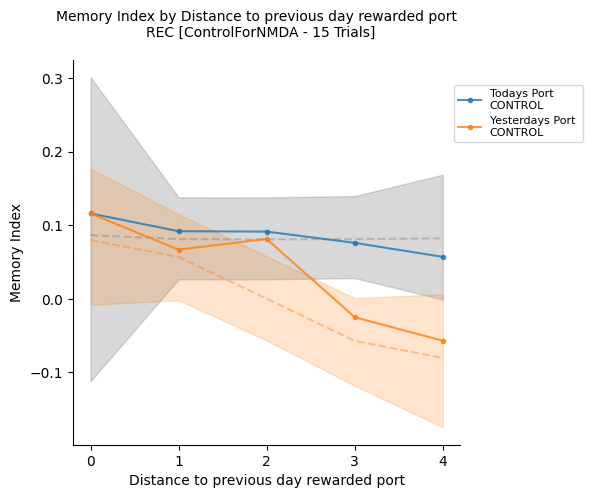

In [ ]:
NumTrials=10
##CONTROL
All_MIShuffREC_List_Dist_means=np.array([np.mean(MI_shuff_Surr[:,0]), np.mean(MI_shuff_Surr[:,1]), np.mean(MI_shuff_Surr[:,2]), np.mean(MI_shuff_Surr[:,3]),np.mean(MI_shuff_Surr[:,4])])
All_MIShuffRECListREC_CI99=np.array([np.percentile(MI_shuff_Surr[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr[:,4], [99.5, .5])])
All_MIShuffREC24_List_Dist_means=np.array([np.mean(MI_shuff_Surr24h[:,0]), np.mean(MI_shuff_Surr24h[:,1]), np.mean(MI_shuff_Surr24h[:,2]), np.mean(MI_shuff_Surr24h[:,3]),np.mean(MI_shuff_Surr24h[:,4])])
All_MIShuffRECListREC24_CI99=np.array([np.percentile(MI_shuff_Surr24h[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr24h[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr24h[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr24h[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr24h[:,4], [99.5, .5])])
##FIGURE
x=np.arange(0, len(MIs_distances_REC), 1)
fig,axs=plt.subplots(figsize=(5,5))
# ##CONTROL
axs.plot( np.array(All_MIShuffREC_List_Dist_means),'--' ,color='grey', alpha=0.4)
axs.fill_between(x, np.array(All_MIShuffRECListREC_CI99)[:,0],np.array(All_MIShuffRECListREC_CI99)[:,1], color='grey', alpha=0.3)
axs.plot(x,MIs_distances_REC, '.-', alpha=0.8 ,label='Todays Port \nCONTROL')
axs.plot( np.array(All_MIShuffREC24_List_Dist_means),'--' ,color='tab:orange', alpha=0.4)
axs.fill_between(x, np.array(All_MIShuffRECListREC24_CI99)[:,0],np.array(All_MIShuffRECListREC24_CI99)[:,1], color='tab:orange', alpha=0.2)
axs.plot(x,MIs_distances24h_REC, '.-', alpha=0.8 ,label='Yesterdays Port \nCONTROL')

# ##NMDA
# All_MIShuffREC_List_Dist_means_NMDA=np.array([np.mean(MI_shuff_Surr_NMDA[:,0]), np.mean(MI_shuff_Surr_NMDA[:,1]), np.mean(MI_shuff_Surr_NMDA[:,2]), np.mean(MI_shuff_Surr_NMDA[:,3]),np.mean(MI_shuff_Surr_NMDA[:,4])])
# All_MIShuffRECListREC_CI99_NMDA=np.array([np.percentile(MI_shuff_Surr_NMDA[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr_NMDA[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr_NMDA[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr_NMDA[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr_NMDA[:,4], [99.5, .5])])
# All_MIShuffREC24_List_Dist_means_NMDA=np.array([np.mean(MI_shuff_Surr24h_NMDA[:,0]), np.mean(MI_shuff_Surr24h_NMDA[:,1]), np.mean(MI_shuff_Surr24h_NMDA[:,2]), np.mean(MI_shuff_Surr24h_NMDA[:,3]),np.mean(MI_shuff_Surr24h_NMDA[:,4])])
# All_MIShuffRECListREC24_CI99_NMDA=np.array([np.percentile(MI_shuff_Surr24h_NMDA[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr24h_NMDA[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr24h_NMDA[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr24h_NMDA[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr24h_NMDA[:,4], [99.5, .5])])

# axs.plot(x,MIs_distances_REC_NMDA, '.-', color='tab:blue',alpha=0.4 ,label='Todays Port \nNMDA')
# axs.fill_between(x, np.array(All_MIShuffRECListREC_CI99_NMDA)[:,0],np.array(All_MIShuffRECListREC_CI99_NMDA)[:,1], color='grey', alpha=0.1)
# axs.plot(x,MIs_distances24h_REC_NMDA, '.-', color='tab:orange',alpha=0.4 ,label='Yesterdays Port \nNMDA')
# axs.fill_between(x, np.array(All_MIShuffRECListREC24_CI99_NMDA)[:,0],np.array(All_MIShuffRECListREC24_CI99_NMDA)[:,1], color='tab:orange', alpha=0.1)

# ##LGI1
# All_MIShuffREC_List_Dist_means_LGI1=np.array([np.mean(MI_shuff_Surr_LGI1[:,0]), np.mean(MI_shuff_Surr_LGI1[:,1]), np.mean(MI_shuff_Surr_LGI1[:,2]), np.mean(MI_shuff_Surr_LGI1[:,3]),np.mean(MI_shuff_Surr_LGI1[:,4])])
# All_MIShuffRECListREC_CI99_LGI1=np.array([np.percentile(MI_shuff_Surr_LGI1[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr_LGI1[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr_LGI1[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr_LGI1[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr_LGI1[:,4], [99.5, .5])])
# All_MIShuffREC24_List_Dist_means_LGI1=np.array([np.mean(MI_shuff_Surr24h_LGI1[:,0]), np.mean(MI_shuff_Surr24h_LGI1[:,1]), np.mean(MI_shuff_Surr24h_LGI1[:,2]), np.mean(MI_shuff_Surr24h_LGI1[:,3]),np.mean(MI_shuff_Surr24h_LGI1[:,4])])
# All_MIShuffRECListREC24_CI99_LGI1=np.array([np.percentile(MI_shuff_Surr24h_LGI1[:,0], [99.5, .5]),np.percentile(MI_shuff_Surr24h_LGI1[:,1], [99.5, .5]),np.percentile(MI_shuff_Surr24h_LGI1[:,2], [99.5, .5]),np.percentile(MI_shuff_Surr24h_LGI1[:,3], [99.5, .5]), np.percentile(MI_shuff_Surr24h_LGI1[:,4], [99.5, .5])])

# axs.plot(x,MIs_distances_REC_LGI1, '.-', color='tab:blue',alpha=0.2 ,label='Todays Port \nLGI1')
# axs.fill_between(x, np.array(All_MIShuffRECListREC_CI99_LGI1)[:,0],np.array(All_MIShuffRECListREC_CI99_LGI1)[:,1], color='grey', alpha=0.1)
# axs.plot(x,MIs_distances24h_REC_LGI1, '.-', color='tab:orange',alpha=0.2 ,label='Yesterdays Port \nLGI1')
# axs.fill_between(x, np.array(All_MIShuffRECListREC24_CI99_LGI1)[:,0],np.array(All_MIShuffRECListREC24_CI99_LGI1)[:,1], color='tab:orange', alpha=0.1)


axs.set_ylabel('Memory Index')
axs.set_xlabel('Distance to previous day rewarded port')
axs.spines[['top', 'right']].set_visible(False)
axs.set_xticks(x)
axs.legend(loc='upper center', bbox_to_anchor=(1.15, .95), fancybox=True, fontsize=8)
# axs.set_ylim(-.3,.4)
fig.suptitle('Memory Index by Distance to previous day rewarded port  \nREC [ControlForNMDA - 15 Trials]',fontsize=10)

In [ ]:
Nshuffles=1000
MI_shuff_Surr_x=np.full((Nshuffles, 5), np.nan)
for n in range(Nshuffles):
  MI_shuff_Surr_x[n]=((surrogastes_distance_big_Hist_MI0_MI4(distance_seq_REC,NON_0_hist_seq_REC, NON_0_port_seq_REC)))

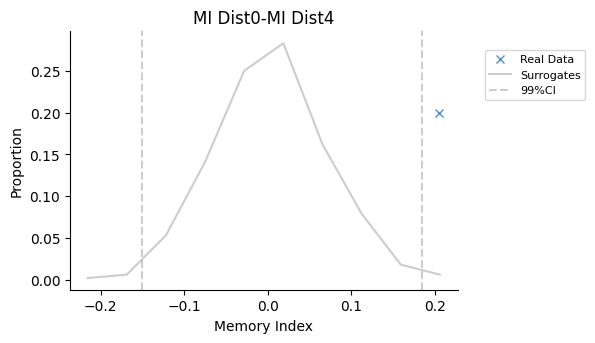

In [ ]:
x=(MIs_distances_REC[0]- MIs_distances_REC[4])
hist0=np.histogram(MI_shuff_Surr_x)
fig,axs=plt.subplots(figsize=(5,5))
axs.plot(x,0.2, 'x', color='tab:blue', alpha=0.8, label='Real Data')
axs.plot(hist0[1][:-1]+(hist0[1][:-1][1]- hist0[1][:-1][0])/2,hist0[0]/np.sum(hist0[0]), label="Surrogates", color='grey', alpha=0.4)
axs.axvline(np.percentile(MI_shuff_Surr_x,[99.5, .5])[0], linestyle='--', color='grey', alpha=0.4, label='99%CI')
axs.axvline(np.percentile(MI_shuff_Surr_x,[99.5, .5])[1], linestyle='--', color='grey', alpha=0.4)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Proportion')
axs.set_xlabel('Memory Index')
axs.set_title('MI Dist0-MI Dist4')
axs.legend(loc='upper center', bbox_to_anchor=(1.20, .95), fancybox=True, fontsize=8)
axs.set_aspect('equal', adjustable='box')
# fig.tight_layout()

In [ ]:
def surrogastes_big_Hist(hist_seq,port_seq ):
  Hist_data = np.array(list(chain.from_iterable(hist_seq)))
  new_port_seq=np.array(list(chain.from_iterable(port_seq)))
  random.shuffle(new_port_seq)

  ## I am centering all the histograms to the 8th port and adding them in a big histogram
  big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)

  return big_hist

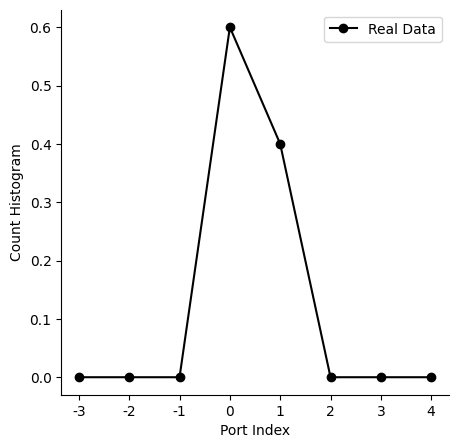

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array([0, 3, 2, 0, 0, 0, 0, 0])
new_port_seq=port_seq[1][-8]
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.roll(Hist_data,4-int(new_port_seq), axis=0)
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
# axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.4, linestyle='-', label='Surrogate Dataset')
# plt.plot(big_hist/np.sum(big_hist), color='black', linestyle='dotted')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
# axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')
axs.legend()

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.4, linestyle='-', label='Surrogate Dataset')
# plt.plot(big_hist/np.sum(big_hist), color='black', linestyle='dotted')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')
axs.legend()

Text(0.5, 0, 'Port Index')

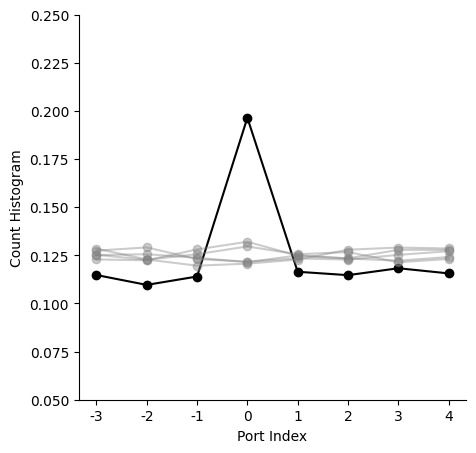

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
# axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.2, linestyle='-', label='Surrogate Dataset: 1 Shuffle')
for i in range(len(Hist_shuff_Surr_5)):
  axs.plot(x,(Hist_shuff_Surr_5[i])/np.sum(Hist_shuff_Surr_5[i]), marker='o', color='grey',alpha=0.4, linestyle='-', label='Surrogate Dataset: 5 Shuffles')
# plt.plot(big_hist/np.sum(big_hist), color='black', linestyle='dotted')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')
# axs.legend()

Text(0.5, 0, 'Port Index')

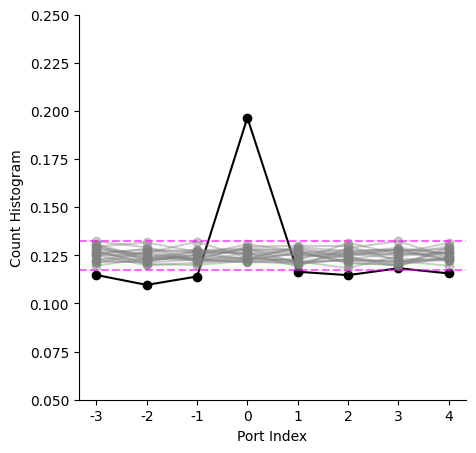

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
# axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.2, linestyle='-', label='Surrogate Dataset: 1 Shuffle')
for i in range(len (Hist_shuff_Surr_20)):
  axs.plot(x,(Hist_shuff_Surr_20[i])/np.sum(Hist_shuff_Surr_20[i]), marker='o', color='grey',alpha=0.4, linestyle='-', label='Surrogate Dataset: 1000 Shuffles')
axs.axhline(percentiles[0], color='magenta', alpha=0.6, linestyle='--')
axs.axhline(percentiles[1], color='magenta', alpha=0.6, linestyle='--', label='99%CI')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')

In [ ]:
hist_normalizado=np.full((Nshuffles, 8), np.nan)
for i in range(len(Hist_shuff_Surr_1000)):
  hist_normalizado[i]=Hist_shuff_Surr_1000[i]/np.sum(Hist_shuff_Surr_1000[i])

Text(0.5, 0, 'Port Index')

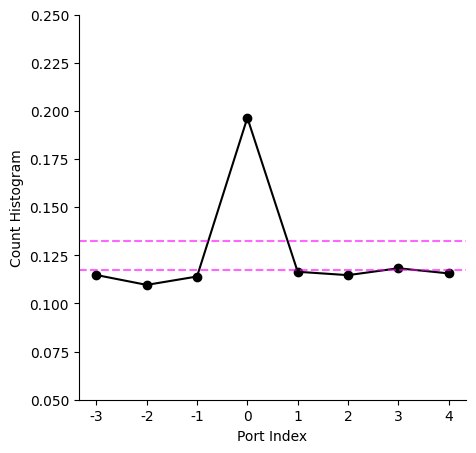

In [ ]:
hist_seq=NON_0_hist_seq_REC
port_seq=NON_0_port_seq_REC

Hist_data = np.array(list(chain.from_iterable(hist_seq)))
new_port_seq=np.array(list(chain.from_iterable(port_seq)))
# new_yes_seq=np.array(list(chain.from_iterable(yes_seq)))

## I am centering all the histograms to the 8th port and adding them in a big histogram
big_hist=np.sum([np.roll(Hist_data[ss],4-int(new_port_seq[ss]), axis=0) for ss in range(len(Hist_data))], axis=0)
percentiles=np.percentile(hist_normalizado, [99.5,0.5])
fig,axs=plt.subplots(figsize=(5,5))
x=np.arange(8)
axs.plot(x,big_hist/np.sum(big_hist), color='black', marker='o', linestyle='-', label='Real Data')
# axs.plot(x,Hist_shuff_Surr_1[0]/np.sum(Hist_shuff_Surr_1[0]), marker='o', color='grey',alpha=0.2, linestyle='-', label='Surrogate Dataset: 1 Shuffle')
# for i in range(len (Hist_shuff_Surr_1000)):
#   axs.plot(x,(Hist_shuff_Surr_1000[i])/np.sum(Hist_shuff_Surr_1000[i]), marker='o', color='grey',alpha=0.1, linestyle='-', label='Surrogate Dataset: 1000 Shuffles')
axs.axhline(percentiles[0], color='magenta', alpha=0.6, linestyle='--')
axs.axhline(percentiles[1], color='magenta', alpha=0.6, linestyle='--', label='99%CI')
xvalues=x
xlabesl=[-3,-2,-1,0,1,2,3,4]
axs.set_xticks(xvalues, xlabesl)
axs.set_ylim(0.05, 0.25)
axs.spines[['top', 'right']].set_visible(False)
axs.set_ylabel('Count Histogram')
axs.set_xlabel('Port Index')

## TESTS

In [ ]:
group1=All_MItrl_REC[0]
group2=All_MItrl_REC[4]
t_statistic, p_valor = stats.ttest_ind(group1, group2)

# Imprimir los resultados
print("Estadística t:", t_statistic)
print("Valor p:", p_valor)

from scipy import stats
group0=All_MItrl_REC[0]
group1=All_MItrl_REC[1]
group2=All_MItrl_REC[2]
group3=All_MItrl_REC[3]
group4=All_MItrl_REC[4]
# Compute ANOVA
f_statistic, p_valor = stats.f_oneway(group0, group1, group2 ,group3, group4)

# Imprimir los resultados
print("Estadística F:", f_statistic)
print("Valor p:", p_valor)

Estadística t: 2.964521030267374
Valor p: 0.003290544575895793


In [ ]:
from scipy import stats
group0=All_MItrl_REC[0]
group1=All_MItrl_REC[1]
group2=All_MItrl_REC[2]
group3=All_MItrl_REC[3]
group4=All_MItrl_REC[4]
# Compute ANOVA
f_statistic, p_valor = stats.f_oneway(group0, group1, group2 ,group3, group4)

# Imprimir los resultados
print("Estadística F:", f_statistic)
print("Valor p:", p_valor)

Estadística F: 3.2271125038459467
Valor p: 0.011938371866308157
